# SmartDelivery: Optimizing Zomato's Operations with Predictive Analytics & Route Efficiency

## Objective

1. Predictive Analytics
  - Develop a machine learning model to estimate delivery times.
  - Perform an analysis comparing actual vs. predicted delivery times.
  - Identify key factors influencing delivery times using feature importance to provide better operational insights.
2. Route Optimization
  - Utilize the OSRM API to retrieve precise distances, estimated durations, and optimal delivery routes.
3. Delivery Performance Analysis
  - Identify underperforming drivers by analyzing their actual delivery times, ratings, average speed, vehicle condition, and total completed deliveries.

## Dataset Description

| No. | Column Name                      | Description                                                      |
|-----|----------------------------------|------------------------------------------------------------------|
| 1   | ID                               | Unique identifier for each delivery.                            |
| 2   | Delivery_person_ID               | Unique identifier for each delivery person.                     |
| 3   | Delivery_person_Age              | Age of the delivery person.                                     |
| 4   | Delivery_person_Ratings          | Ratings assigned to the delivery person.                        |
| 5   | Restaurant_latitude              | Latitude of the restaurant.                                     |
| 6   | Restaurant_longitude             | Longitude of the restaurant.                                    |
| 7   | Delivery_location_latitude       | Latitude of the delivery location.                              |
| 8   | Delivery_location_longitude      | Longitude of the delivery location.                             |
| 9   | Order_Date                       | Date of the order.                                              |
| 10  | Time_Ordered                     | Time the order was placed.                                      |
| 11  | Time_Order_picked                | Time the order was picked up for delivery.                      |
| 12  | Weather_conditions               | Weather conditions at the time of delivery.                     |
| 13  | Road_traffic_density             | Density of road traffic during delivery.                        |
| 14  | Vehicle_condition                | Condition of the delivery vehicle.                              |
| 15  | Type_of_order                    | Type of order (e.g., dine-in, takeaway, delivery).              |
| 16  | Type_of_vehicle                  | Type of vehicle used for delivery.                              |
| 17  | Multiple_deliveries              | Indicator of whether multiple deliveries were made in the same trip. |
| 18  | Festival                         | Indicator of whether the delivery coincided with a festival.    |
| 19  | City                             | City where the delivery took place.                             |
| 20  | Time_taken (min)                 | Time taken for delivery in minutes.                             |


# Importing Library

In [1]:
!pip install polyline
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.7 MB/s eta 0:00:00


In [2]:
import os
import ast
import json
import time
import joblib
import folium
import requests
import polyline
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from datetime import datetime as dtime

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Loading Data and Exploration

## Fetch OSRM Data Locally

In [3]:
# # Read the dataset from local computer
# df = pd.read_csv('Zomato Dataset.csv')

In [4]:
# df.head()

In [5]:
# def get_vehicle_route(restaurant_lat, restaurant_lon, delivery_lat, delivery_lon):
#     """
#     Calculate vehicle route metrics using local OSRM instance
#     Returns: (distance_meters, time_minutes, route_coordinates) or (None, None, None) on error
#     """
#     # OSRM API endpoint (coordinates format: lon,lat)
#     coords = f"{restaurant_lon},{restaurant_lat};{delivery_lon},{delivery_lat}"
#     url = f"http://localhost:5000/route/v1/car/{coords}"

#     params = {
#         "alternatives": "false",
#         "steps": "false",
#         "overview": "full",  # Get full route geometry
#         "geometries": "polyline"
#     }

#     try:
#         response = requests.get(url, params=params)
#         response.raise_for_status()
#         data = response.json()

#         if data['code'] != 'Ok' or not data['routes']:
#             return {'distance_osrm': None,
#                     'duration_osrm': None,
#                     'route_coordinates_osrm': None}

#         route = data['routes'][0]
#         distance = route['distance']  # In meters
#         duration = route['duration'] / 60  # Convert seconds to minutes
#         geometry = polyline.decode(route['geometry'])  # Decode polyline to coordinates

#         return {'distance_osrm': distance,
#                 'duration_osrm': round(duration, 2),
#                 'route_coordinates_osrm': geometry}

#     except Exception as e:
#         print(f"Error: {e}")
#         return {'distance_osrm': None,
#                 'duration_osrm': None,
#                 'route_coordinates_osrm': None}

In [6]:
# def process_routes(df):
#     start_time = time.time()

#     results = []
#     for i, row in df.iterrows():
#         restaurant_lat = row['Restaurant_latitude']
#         restaurant_lon = row['Restaurant_longitude']
#         delivery_lat = row['Delivery_location_latitude']
#         delivery_lon = row['Delivery_location_longitude']

#         result = get_vehicle_route(restaurant_lat, restaurant_lon, delivery_lat, delivery_lon)
#         results.append(result)

#         # Print the time taken every 100 rows
#         if (i + 1) % 100 == 0:
#             elapsed_time = time.time() - start_time
#             print(f"Processed {i + 1} rows in {elapsed_time:.2f} seconds")

#     return results

In [7]:
# # Get the results -> distance_osrm, duration_osrm, route_coordinates_osrm
# results = process_routes(df)

In [8]:
# # Convert it to a DataFrame
# df_osrm = pd.DataFrame(results)

In [9]:
# df_osrm.head()

In [10]:
# # Merge the OSRM parameters with the original DataFrame
# merged_df = pd.concat([df, df_osrm], axis=1)

In [11]:
# # Save it as a CSV file for further processing
# merged_df.to_csv("zomato_dataset_with_osrm_params.csv", index=False)

## Filling missing values in the City column

In [12]:
# # Load the dataset
# file_path = '/content/drive/MyDrive/Zomato Project/dataset/zomato_dataset_with_osrm_params.csv'
# df = pd.read_csv(file_path)

In [13]:
# df['City'].isna().sum()

In [14]:
# def get_city_category(lat, lon):
#     try:
#         # Using Nominatim (OpenStreetMap's geocoding service)
#         url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={lat}&lon={lon}"
#         headers = {'User-Agent': 'YourAppName/1.0'}  # Required by Nominatim
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()
#         data = response.json()

#         # Get the address components
#         address = data.get('address', {})

#         # Check for metropolitan areas (cities with type 'city')
#         if address.get('city') and data.get('type') == 'city':
#             return "Metropolitan"

#         # Check for urban areas (towns or cities not classified as metropolitan)
#         if address.get('town') or address.get('city'):
#             return "Urban"

#         # Everything else falls into Semi-Urban
#         return "Semi-Urban"

#     except Exception as e:
#         print(f"Geocoding error: {e}")
#         return None

In [15]:
# # Sample for estimating fetching time
# df = df.copy().sample(1000)

In [16]:
# # Identify missing rows in the 'City' column
# city_missing_sum = df['City'].isna().sum()
# print(city_missing_sum)

In [17]:
# missing_city_indices = df['City'].isna()

In [18]:
# df['City'].loc[[26715,35030,32133,39719,35872,10392]]

In [19]:
# %%time

# # Fill missing values using the get_city_category function
# df.loc[missing_city_indices, 'City'] = df.loc[missing_city_indices].apply(
#     lambda row: get_city_category(row['Restaurant_latitude'], row['Restaurant_longitude']),
#     axis=1
# )

In [20]:
# # Check again
# city_missing_sum = df['City'].isna().sum()
# print(city_missing_sum)

In [21]:
# df['City'].loc[[26715,35030,32133,39719,35872,10392]]

In [22]:
# df.to_csv("/content/drive/MyDrive/Zomato Project/dataset/zomato_dataset_with_osrm_params_and_imputed_city.csv", index=False)

## Filling missing values in the Weather column

In [23]:
# # Load the dataset
# file_path = '/content/drive/MyDrive/Zomato Project/dataset/zomato_dataset_with_osrm_params_and_imputed_city.csv'
# df = pd.read_csv(file_path)

In [24]:
# df['Weather_conditions'].isna().sum()

In [25]:
# df['Weather_conditions'].value_counts()

In [26]:
# df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y', errors='coerce')

In [27]:
# df['Order_Date'].head()

In [28]:
# # Define mapping (adjust as needed)
# weather_mapping = {
#     "Clear": "Sunny",
#     "Sunny": "Sunny",
#     "Clouds": "Cloudy",
#     "Overcast": "Cloudy",
#     "Rain": "Stormy",
#     "Thunderstorm": "Stormy",
#     "Snow": "Stormy",
#     "Fog": "Fog",
#     "Mist": "Fog",
#     "Haze": "Fog",
#     "Dust": "Sandstorms",
#     "Sand": "Sandstorms",
#     "Windy": "Windy",
#     "Squall": "Windy",
#     "Tornado": "Stormy"
# }

In [29]:
# # Function to fetch weather
# def get_weather(date, lat, lon, api_key):
#     # Convert date to UNIX timestamp (OpenWeatherMap requires this)
#     date_unix = int(datetime.strptime(date, "%Y-%m-%d").timestamp())

#     # API request (OneCall API for historical data)
#     url = f"https://api.openweathermap.org/data/2.5/onecall/timemachine?lat={lat}&lon={lon}&dt={date_unix}&appid={api_key}"
#     response = requests.get(url).json()

#     # Get weather condition (e.g., "Rain", "Clear")
#     api_weather = response['current']['weather'][0]['main']

#     # Map to your categories
#     return weather_mapping.get(api_weather, "Sunny")  # Default to Sunny if no match

In [30]:
# # Sample for estimating fetching time
# df = df.copy().sample(2000)

In [31]:
# df['Weather_conditions'].isna().sum()

In [32]:
# df['Weather_conditions'].loc[[979,5341,45279,33290,29398]]

In [33]:
# # Apply to missing values
# api_key = "Replace_with_your_api_key"
# for index, row in df[df['Weather_conditions'].isna()].iterrows():
#     try:
#         weather = get_weather(row['Order_Date'], row['Delivery_location_latitude'], row['Delivery_location_longitude'], api_key)
#         df.at[index, 'Weather_conditions'] = weather
#     except:
#         df.at[index, 'Weather_conditions'] = "Sunny"  # Fallback if API fails

In [34]:
# df['Weather_conditions'].loc[[979,5341,45279,33290,29398]]

In [35]:
# df['Weather_conditions'].isna().sum()

In [36]:
# df['Weather_conditions'].value_counts()

In [37]:
# df.to_csv("/content/drive/MyDrive/Zomato Project/dataset/zomato_dataset_with_osrm_params_and_imputed_city_and_weather.csv", index=False)

## Use the Zomato dataset with OSRM parameters and the filled City and Weather columns

In [38]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Load the dataset
file_path = '/content/drive/MyDrive/Zomato Project/dataset/zomato_dataset_with_osrm_params_and_imputed_city_and_weather.csv'
df = pd.read_csv(file_path)

In [40]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),distance_osrm,duration_osrm,route_coordinates_osrm
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,21:55,...,2,Snack,motorcycle,3.0,No,Metropolitian,46,11620.1,16.05,"[(30.32798, 78.04607), (30.32788, 78.04602), (..."
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,2022-02-13,14:55,...,1,Meal,motorcycle,1.0,No,Metropolitian,23,8882.1,13.06,"[(10.00325, 76.30748), (10.00308, 76.3072), (1..."
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,2022-03-04,17:30,...,1,Drinks,scooter,1.0,No,Metropolitian,21,21411.0,18.68,"[(18.56307, 73.91712), (18.56305, 73.91715), (..."
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,2022-02-13,09:20,...,0,Buffet,motorcycle,0.0,No,Metropolitian,20,4833.2,8.33,"[(30.89958, 75.80932), (30.89905, 75.80938), (..."
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,2022-02-14,19:50,...,1,Snack,scooter,1.0,No,Metropolitian,41,23500.8,24.38,"[(26.46341, 80.37304), (26.46336, 80.37302), (..."


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  float64
 4   Restaurant_latitude          45584 non-null  float64
 5   Restaurant_longitude         45584 non-null  float64
 6   Delivery_location_latitude   45584 non-null  float64
 7   Delivery_location_longitude  45584 non-null  float64
 8   Order_Date                   45584 non-null  object 
 9   Time_Orderd                  43853 non-null  object 
 10  Time_Order_picked            45584 non-null  object 
 11  Weather_conditions           45584 non-null  object 
 12  Road_traffic_density         44983 non-null  object 
 13  Vehicle_conditio

As we can see, there are still missing values in our dataset

# Data Preprocessing I

## Handling Duplicate Data

In [42]:
# Check duplicate data
df.duplicated().sum().sum()

np.int64(0)

## Transforming Distance to Kilometers

In [43]:
# Create a new column with distance in kilometers
df['distance_osrm_km'] = df['distance_osrm'] / 1000

In [44]:
# Drop the old column
df = df.drop(columns=['distance_osrm'])

## Handling Error Data

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  float64
 4   Restaurant_latitude          45584 non-null  float64
 5   Restaurant_longitude         45584 non-null  float64
 6   Delivery_location_latitude   45584 non-null  float64
 7   Delivery_location_longitude  45584 non-null  float64
 8   Order_Date                   45584 non-null  object 
 9   Time_Orderd                  43853 non-null  object 
 10  Time_Order_picked            45584 non-null  object 
 11  Weather_conditions           45584 non-null  object 
 12  Road_traffic_density         44983 non-null  object 
 13  Vehicle_conditio

Pandas DataFrame can automatically convert a numeric column to an object type if it contains even a single non-numeric value. Therefore, if a column retains its numeric type, its data distribution can be directly analyzed using `df.describe()`.

For categorical columns, data errors should be reviewed per column to ensure consistency and accuracy.

In [46]:
df[['Delivery_person_Age','Delivery_person_Ratings','Vehicle_condition','multiple_deliveries','Time_taken (min)','distance_osrm_km','duration_osrm']].describe()

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,multiple_deliveries,Time_taken (min),distance_osrm_km,duration_osrm
count,43730.000000,43676.000000,45584.000000,44591.000000,45584.000000,45546.000000,45546.000000
mean,29.566911,4.633774,1.023385,0.744635,26.293963,27.375734,26.030662
std,5.815064,0.334744,0.839055,0.572510,9.384298,169.478622,129.964371
min,15.000000,1.000000,0.000000,0.000000,10.000000,0.000000,0.000000
25%,25.000000,4.500000,0.000000,0.000000,19.000000,5.956500,7.870000
50%,30.000000,4.700000,1.000000,1.000000,26.000000,12.127300,14.540000
75%,35.000000,4.900000,2.000000,1.000000,32.000000,18.352400,21.010000
max,50.000000,6.000000,3.000000,3.000000,54.000000,3085.817100,2349.570000


For the numeric variables mentioned above, the `.describe()` output indicates no unusual values, such as random numbers, infinities (inf), or other anomalies.

In [47]:
df["ID"].value_counts().sort_index()

,count
ID,
0x1000,1
0x1001,1
0x1002,1
0x1003,1
0x1004,1
...,...
0xffa,1
0xffb,1
0xffc,1


In [48]:
df["Delivery_person_ID"].value_counts().sort_index()

,count
Delivery_person_ID,
AGRRES010DEL01,14
AGRRES010DEL02,15
AGRRES010DEL03,13
AGRRES01DEL01,12
AGRRES01DEL02,14
...,...
VADRES19DEL02,59
VADRES19DEL03,41
VADRES20DEL01,59


In [49]:
df["Order_Date"].value_counts().sort_index()

,count
Order_Date,
2022-02-11,970
2022-02-12,864
2022-02-13,957
2022-02-14,851
2022-02-15,945
2022-02-16,861
2022-02-17,939
2022-02-18,855
2022-03-01,1140


In [50]:
pd.set_option('display.max_rows', None)

In [51]:
df["Time_Orderd"].value_counts().sort_index()

,count
Time_Orderd,
0.375,177
0.416666667,211
0.458333333,193
0.5,189
0.541666667,79
0.583333333,74
0.625,86
0.666666667,53
0.708333333,66


In [52]:
df["Time_Order_picked"].value_counts().sort_index()

,count
Time_Order_picked,
0.375,201
0.416666667,194
0.458333333,148
0.5,188
0.541666667,83
0.583333333,82
0.625,100
0.666666667,91
0.708333333,66


The values in `Time_Ordered` and `Time_Order_picked` that are not in HH:MM format appear to be decimal representations of time in Excel's time format. In Excel, times are stored as fractions of a 24-hour day. Therefore, these values need to be converted back to the standard HH:MM format.

In [53]:
pd.reset_option('display.max_rows')

In [54]:
def convert_time(time_val):
    if pd.isna(time_val):
        return np.nan  # Skip the NaN entries for now

    # Case 1: Already in "HH:MM" or "HH:MM:SS" format
    if isinstance(time_val, str) and ":" in time_val:
        parts = time_val.split(":")
        if len(parts) >= 2:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                # Convert 24:xx to 00:xx (next day)
                if hours >= 24:
                    hours = hours % 24
                return f"{hours:02d}:{minutes:02d}"  # Standard time format
            except (ValueError, IndexError):
                pass  # Fall through to decimal conversion

    # Case 2: Decimal time (Excel format)
    try:
        decimal_time = float(time_val)
        total_seconds = decimal_time * 24 * 3600
        hours = int(total_seconds // 3600)
        minutes = int((total_seconds % 3600) // 60)
        # Handle cases where hours might be >= 24
        hours = hours % 24
        return f"{hours:02d}:{minutes:02d}"  # No seconds
    except (ValueError, TypeError):
        return np.nan  # Invalid entry

In [55]:
df.iloc[[6277	, 40977, 43947, 40795, 36726, 30720]][['Time_Orderd','Time_Order_picked']]

,Time_Orderd,Time_Order_picked
6277,0.5,12:10
40977,0.458333333,11:15
43947,0.458333333,11:10
40795,23:45,1
36726,23:55,24:05:00
30720,21:45,0.916666667


In [56]:
# Apply conversion to the column
df['Time_Orderd'] = df['Time_Orderd'].apply(convert_time)
df['Time_Order_picked'] = df['Time_Order_picked'].apply(convert_time)

In [57]:
df.iloc[[6277	, 40977, 43947, 40795, 36726, 30720]][['Time_Orderd','Time_Order_picked']]

,Time_Orderd,Time_Order_picked
6277,12:00,12:10
40977,10:59,11:15
43947,10:59,11:10
40795,23:45,00:00
36726,23:55,00:05
30720,21:45,22:00


In [58]:
df["Time_Orderd"].value_counts().sort_index()

,count
Time_Orderd,
00:00,430
08:10,167
08:15,177
08:20,183
08:25,178
...,...
23:35,422
23:40,419
23:45,405


In [59]:
df["Time_Order_picked"].value_counts().sort_index()

,count
Time_Order_picked,
00:00,440
00:05,435
00:10,280
00:15,165
08:15,48
...,...
23:35,443
23:40,406
23:45,432


In [60]:
df["Weather_conditions"].value_counts().sort_index()

,count
Weather_conditions,
Cloudy,7533
Fog,7653
Sandstorms,7494
Stormy,7584
Sunny,7898
Windy,7422


In [61]:
df["Road_traffic_density"].value_counts().sort_index()

,count
Road_traffic_density,
High,4423
Jam,14139
Low,15476
Medium,10945


In [62]:
df["Type_of_order"].value_counts().sort_index()

,count
Type_of_order,
Buffet,11277
Drinks,11321
Meal,11456
Snack,11530


In [63]:
df["Type_of_vehicle"].value_counts().sort_index()

,count
Type_of_vehicle,
bicycle,68
electric_scooter,3814
motorcycle,26429
scooter,15273


In [64]:
df["Festival"].value_counts().sort_index()

,count
Festival,
No,44460
Yes,896


In [65]:
df["City"].value_counts().sort_index()

,count
City,
Metropolitian,34087
Semi-Urban,469
Urban,11028


In [66]:
df["Restaurant_latitude"].value_counts().sort_index()

,count
Restaurant_latitude,
-30.905562,1
-30.902872,2
-30.899584,3
-30.895817,3
-30.893384,1
...,...
30.899584,41
30.899992,38
30.902872,32


In [67]:
df["Restaurant_longitude"].value_counts().sort_index()

,count
Restaurant_longitude,
-88.366217,1
-88.352885,1
-88.349843,1
-88.322337,1
-85.339820,1
...,...
88.393310,36
88.400467,33
88.400581,34


In [68]:
df["Delivery_location_latitude"].value_counts().sort_index()

,count
Delivery_location_latitude,
0.010000,327
0.020000,337
0.030000,313
0.040000,335
0.050000,328
...,...
31.039992,3
31.042872,2
31.044057,4


In [69]:
df["Delivery_location_longitude"].value_counts().sort_index()

,count
Delivery_location_longitude,
0.010000,327
0.020000,337
0.030000,313
0.040000,335
0.050000,328
...,...
88.530581,4
88.543187,4
88.543452,3


In [70]:
def plot_coord_map(df, coord_type='restaurant', output_file='/content/drive/MyDrive/Zomato Project/map/restaurant_coord_map.html'):
    map_center = [20.5937, 78.9629]  # Coordinates for the center of India
    zoom_start = 3

    m = folium.Map(location=map_center, zoom_start=zoom_start)

    if coord_type == 'restaurant':
        lon_col = 'Restaurant_longitude'
        lat_col = 'Restaurant_latitude'
        cluster_col = 'pickup_cluster'
        colors = {0: 'orange', 1: 'darkblue', 2: 'darkgreen', 3: 'darkred'}
    elif coord_type == 'delivery':
        lon_col = 'Delivery_location_longitude'
        lat_col = 'Delivery_location_latitude'
        cluster_col = 'dropoff_cluster'
        colors = {0: 'black', 1: 'teal', 2: 'purple'}
    else:
        raise ValueError("coord_type must be either 'pickup' or 'dropoff'")

    marker_group = folium.FeatureGroup(name='Markers')
    for i, row in df.iterrows():
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=3,
            # color=colors[row[cluster_col]],
            fill=True,
            # fill_color=colors[row[cluster_col]],
            fill_opacity=0.1,
            popup=f"Index {i}",
            opacity=0.7
        ).add_to(marker_group)

    marker_group.add_to(m)
    folium.LayerControl().add_to(m)

    m.save(output_file)
    print(f"Map has been saved to {output_file}")

In [71]:
# %%time
# # running time = 1-2 min
# plot_coord_map(df)

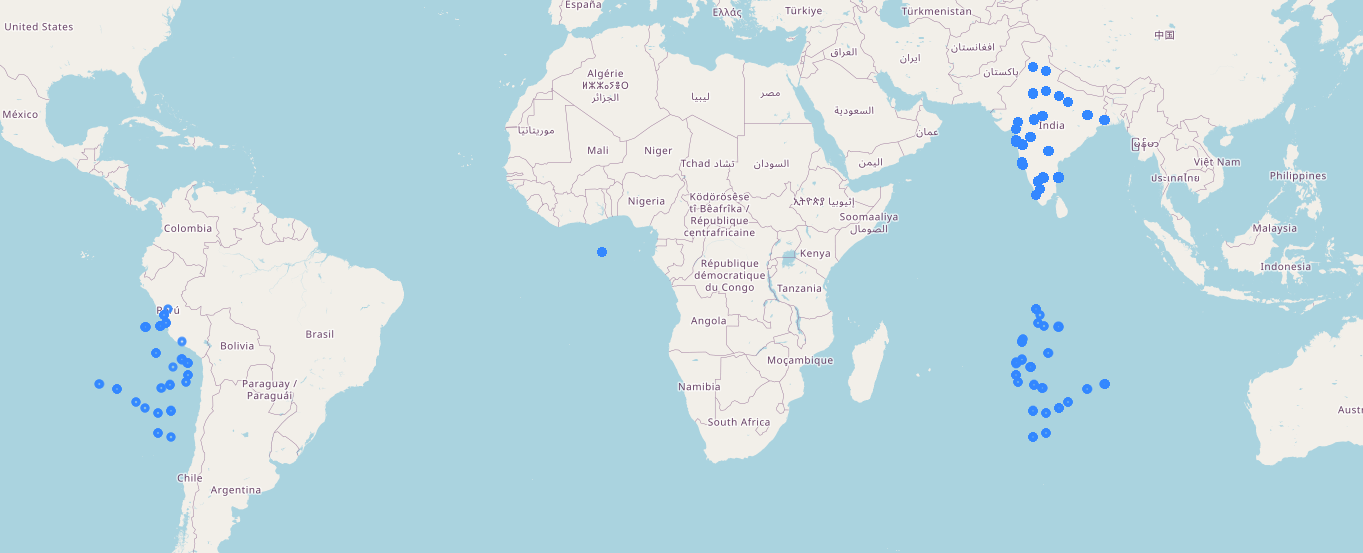

As we can see from the map above, there are coordinates in the ocean that we should remove as they are anomalous.

Filtering where Latitude and longitude is zero (error coordinate):

In [72]:
# Identifying the error coordinates
error_coordinate = df[
    (df['Restaurant_latitude'] == 0) |
    (df['Restaurant_longitude'] == 0) |
    (df['Delivery_location_latitude'] == 0) |
    (df['Delivery_location_longitude'] == 0)
]

In [73]:
error_coordinate[['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']]

,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude
24,0.0,0.0,0.11,0.11
43,0.0,0.0,0.03,0.03
48,0.0,0.0,0.08,0.08
50,0.0,0.0,0.06,0.06
58,0.0,0.0,0.02,0.02
...,...,...,...,...
45560,0.0,0.0,0.07,0.07
45567,0.0,0.0,0.13,0.13
45568,0.0,0.0,0.09,0.09
45570,0.0,0.0,0.05,0.05


In [74]:
initial_df_len = len(df)

In [75]:
# Excluding error coordinates from df
df = df[
    ~(
        (df['Restaurant_latitude'] == 0) |
        (df['Restaurant_longitude'] == 0) |
        (df['Delivery_location_latitude'] == 0) |
        (df['Delivery_location_longitude'] == 0)
    )
]

In [76]:
# Reset index after dropped the rows
df.reset_index(drop=True, inplace=True)

In [77]:
# Verify it again
df[
    (df['Restaurant_latitude'] == 0) |
    (df['Restaurant_longitude'] == 0) |
    (df['Delivery_location_latitude'] == 0) |
    (df['Delivery_location_longitude'] == 0)
]

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),duration_osrm,route_coordinates_osrm,distance_osrm_km


In [78]:
india_bounds = {
    "latitude_min": 8.4,
    "latitude_max": 37.6,
    "longitude_min": 68.7,
    "longitude_max": 97.4
}

In [79]:
# Delivery Coordinate

# Filter rows within the boundary
within_bounds_delivery = df[
    (df['Delivery_location_latitude'] >= india_bounds['latitude_min']) &
    (df['Delivery_location_latitude'] <= india_bounds['latitude_max']) &
    (df['Delivery_location_longitude'] >= india_bounds['longitude_min']) &
    (df['Delivery_location_longitude'] <= india_bounds['longitude_max'])
]

# Filter rows outside the boundary
outside_bounds_delivery = df[
    (df['Delivery_location_latitude'] < india_bounds['latitude_min']) |
    (df['Delivery_location_latitude'] > india_bounds['latitude_max']) |
    (df['Delivery_location_longitude'] < india_bounds['longitude_min']) |
    (df['Delivery_location_longitude'] > india_bounds['longitude_max'])
]

In [80]:
# Restaurant Coordinate

# Filter rows within the boundary
within_bounds_restaurant = df[
    (df['Restaurant_latitude'] >= india_bounds['latitude_min']) &
    (df['Restaurant_latitude'] <= india_bounds['latitude_max']) &
    (df['Restaurant_longitude'] >= india_bounds['longitude_min']) &
    (df['Restaurant_longitude'] <= india_bounds['longitude_max'])
]

# Filter rows outside the boundary
outside_bounds_restaurant = df[
    (df['Restaurant_latitude'] < india_bounds['latitude_min']) |
    (df['Restaurant_latitude'] > india_bounds['latitude_max']) |
    (df['Restaurant_longitude'] < india_bounds['longitude_min']) |
    (df['Restaurant_longitude'] > india_bounds['longitude_max'])
]

In [81]:
outside_bounds_delivery[['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']]

,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude


In [82]:
outside_bounds_restaurant[['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']]

,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude
73,-27.163303,78.057044,27.233303,78.127044
250,-27.165108,78.015053,27.225108,78.075053
255,-18.551440,-73.804855,18.611440,73.864855
378,-30.366322,-78.070453,30.496322,78.200453
479,-12.325461,-76.632278,12.385461,76.692278
...,...,...,...,...
41337,-19.874733,75.353942,19.904733,75.383942
41417,-18.514210,73.838429,18.524210,73.848429
41498,-15.493950,-73.827423,15.563950,73.897423
41567,-26.482581,80.315628,26.532581,80.365628


There are no coordinates outside the boundaries of India for the Delivery Coordinates.

However, there are coordinates outside the boundaries of India for the Restaurant Coordinates.

In [83]:
# Filtering the Restaurant Coordinate

# Filter rows within the boundary and update the original DataFrame
df = df[
    (df['Restaurant_latitude'] >= india_bounds['latitude_min']) &
    (df['Restaurant_latitude'] <= india_bounds['latitude_max']) &
    (df['Restaurant_longitude'] >= india_bounds['longitude_min']) &
    (df['Restaurant_longitude'] <= india_bounds['longitude_max'])
]

# Reset index
df.reset_index(drop=True, inplace=True)

In [84]:
print(f"The initial length of the dataset: {initial_df_len:,}")
print(f"Removed data: {initial_df_len-len(df):,} ({(initial_df_len-len(df))/initial_df_len*100:.1f}%)")
print(f"The new length of the dataset: {len(df):,}")

The initial length of the dataset: 45,584
Removed data: 4,071 (8.9%)
The new length of the dataset: 41,513


# Splitting the Dataset

In [85]:
X = df.drop(columns="Time_taken (min)", axis=1)
y = df["Time_taken (min)"]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [87]:
# Concat the X_train and y_train
train = pd.concat([X_train, y_train], axis=1)

In [88]:
# Concat the X_test and y_test
test = pd.concat([X_test, y_test], axis=1)

In [89]:
print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (33210, 23)
test: (8303, 23)


# Data Preprocessing II

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33210 entries, 22513 to 15795
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           33210 non-null  object 
 1   Delivery_person_ID           33210 non-null  object 
 2   Delivery_person_Age          32029 non-null  float64
 3   Delivery_person_Ratings      31996 non-null  float64
 4   Restaurant_latitude          33210 non-null  float64
 5   Restaurant_longitude         33210 non-null  float64
 6   Delivery_location_latitude   33210 non-null  float64
 7   Delivery_location_longitude  33210 non-null  float64
 8   Order_Date                   33210 non-null  object 
 9   Time_Orderd                  32158 non-null  object 
 10  Time_Order_picked            33210 non-null  object 
 11  Weather_conditions           33210 non-null  object 
 12  Road_traffic_density         32880 non-null  object 
 13  Vehicle_condition

## Handling Missing Values

In [91]:
train.isna().sum()[train.isna().sum() > 0].sort_values(ascending=False)

,0
Delivery_person_Ratings,1214
Delivery_person_Age,1181
Time_Orderd,1052
multiple_deliveries,714
Road_traffic_density,330
Festival,171


In [92]:
missing_percent = (train.isna().sum() / len(train)) * 100
missing_percent = missing_percent.round(2)  # Round to 2 decimal places
missing_percent = missing_percent[missing_percent > 0]  # Show only columns with missing values
missing_percent.sort_values(ascending=False)  # Sort by percentage descending

,0
Delivery_person_Ratings,3.66
Delivery_person_Age,3.56
Time_Orderd,3.17
multiple_deliveries,2.15
Road_traffic_density,0.99
Festival,0.51


As shown in the table above, many features still contain missing values.

---

**Removing rows where 6 or more out of 18 (original features) (≥ 30%) columns have missing values**

Since the loss is minimal and imputing 33% missing features in a row is risky (could introduce noise), dropping is justified

In [93]:
# Check which rows have exactly 6 missing values
rows_with_6_missing = train[train.isnull().sum(axis=1) >= 6]

# Show which rows have exactly 6 missing entries
if not rows_with_6_missing.empty:
    print("Rows with exactly 6 missing entries:")
    print(len(rows_with_6_missing))
    result_train = rows_with_6_missing
else:
    print("No rows with exactly 6 missing entries found.")

No rows with exactly 6 missing entries found.


---

**Delivery_person_Age** and **Delivery_person_Ratings**

In [94]:
train[train['Delivery_person_Age'].isna()][['Delivery_person_Age', 'Delivery_person_Ratings']].head()

,Delivery_person_Age,Delivery_person_Ratings
26717,NaN,NaN
10963,NaN,NaN
119,NaN,NaN
10245,NaN,NaN
37100,NaN,NaN


In [95]:
# Check if Age and Ratings are missing for the same rows
missing_age = train['Delivery_person_Age'].isna()
missing_ratings = train['Delivery_person_Ratings'].isna()

print(f"Rows missing both Age and Ratings: {(missing_age & missing_ratings).sum()}")
print(f"Rows missing only Age: {(missing_age & ~missing_ratings).sum()}")
print(f"Rows missing only Ratings: {(~missing_age & missing_ratings).sum()}")

Rows missing both Age and Ratings: 1181
Rows missing only Age: 0
Rows missing only Ratings: 33


In [96]:
train[['Delivery_person_Age', 'Delivery_person_Ratings']].describe()

,Delivery_person_Age,Delivery_person_Ratings
count,32029.000000,31996.000000
mean,29.571732,4.632538
std,5.794804,0.328662
min,15.000000,1.000000
25%,25.000000,4.500000
50%,30.000000,4.700000
75%,35.000000,4.900000
max,50.000000,6.000000


In [97]:
# Calculate medians of train features
median_age_train = train['Delivery_person_Age'].median()
median_ratings_train = train['Delivery_person_Ratings'].median()

In [98]:
# Fill train with the medians of its features
train['Delivery_person_Age'] = train['Delivery_person_Age'].fillna(median_age_train)
train['Delivery_person_Ratings'] = train['Delivery_person_Ratings'].fillna(median_ratings_train)

In [99]:
# Fill test with the medians of train features
test['Delivery_person_Age'] = test['Delivery_person_Age'].fillna(median_age_train)
test['Delivery_person_Ratings'] = test['Delivery_person_Ratings'].fillna(median_ratings_train)

In [100]:
train[['Delivery_person_Age', 'Delivery_person_Ratings']].describe()

,Delivery_person_Age,Delivery_person_Ratings
count,33210.000000,33210.000000
mean,29.586962,4.635005
std,5.691385,0.322847
min,15.000000,1.000000
25%,25.000000,4.500000
50%,30.000000,4.700000
75%,34.000000,4.800000
max,50.000000,6.000000


As observed from the distribution, there is no significant skew before or after median imputation. This ensures that the age and ratings values remain realistic without introducing distortions to the dataset.

---

**Festival**

In [101]:
train['Festival'].value_counts()

,count
Festival,
No,32385
Yes,654


In [102]:
train['Festival'] = train['Festival'].fillna('Unknown')
test['Festival'] = test['Festival'].fillna('Unknown')

Since we have no reliable way to impute the missing values for the "festival" feature, categorizing them as "Unknown" is the safest choice.

---

**multiple_deliveries**

In [103]:
train['multiple_deliveries'].value_counts()

,count
multiple_deliveries,
1.0,20505
0.0,10287
2.0,1451
3.0,253


In [104]:
# Calculate mode of multiple_deliveries in train
mode_value_train = train['multiple_deliveries'].mode()[0]
print(f"The mode of 'multiple_deliveries' in train is: {mode_value_train}")

The mode of 'multiple_deliveries' in train is: 1.0


In [105]:
# Fill train with the mode of its features
train['multiple_deliveries'] = train['multiple_deliveries'].fillna(mode_value_train)

In [106]:
# Fill test with the mode of train features
test['multiple_deliveries'] = test['multiple_deliveries'].fillna(mode_value_train)

---

**Road_traffic_density**

To fill the missing values in the `Road_traffic_density` feature, I attempted to impute them based on typical traffic levels depending on the time-of-day intervals—classifying them as low, medium, high, or jam.

In [107]:
train['Road_traffic_density'].value_counts()

,count
Road_traffic_density,
Low,11312
Jam,10348
Medium,8023
High,3197


In [108]:
# Convert categorical to numerical for plotting
traffic_order = {'Low': 0, 'Medium': 1, 'High': 2, 'Jam': 3}
train['Traffic_num'] = train['Road_traffic_density'].map(traffic_order)

In [109]:
# Convert to datetime and extract hour
train['Hour_picked'] = pd.to_datetime(train['Time_Order_picked'], format='%H:%M', errors='coerce').dt.hour

In [110]:
# Drop rows with invalid times (if any)
train = train.dropna(subset=['Hour_picked'])

In [111]:
# Group by hour and traffic level
traffic_by_hour = train.groupby(['Hour_picked', 'Traffic_num']).size().unstack()

In [112]:
traffic_by_hour

Traffic_num,0.0,1.0,2.0,3.0
Hour_picked,,,,
0,935.0,NaN,NaN,NaN
8,1083.0,NaN,NaN,NaN
9,1467.0,NaN,NaN,NaN
10,1649.0,NaN,NaN,NaN
11,293.0,NaN,1036.0,NaN
12,NaN,NaN,826.0,NaN
13,NaN,NaN,633.0,NaN
14,NaN,NaN,520.0,NaN
15,NaN,465.0,182.0,NaN


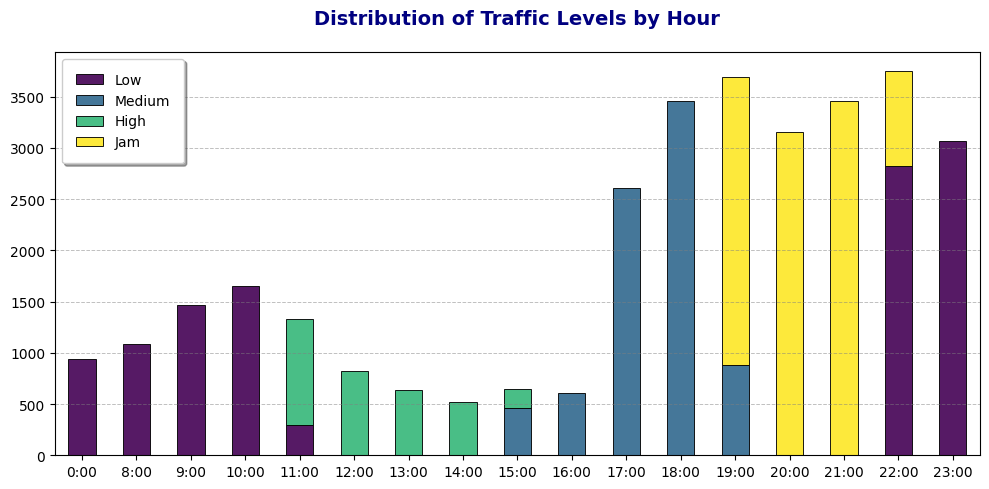

In [113]:
fig, ax = plt.subplots(figsize=(10, 5))  # Define figure and axes

# Plot stacked bars directly on the axes
traffic_by_hour.plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    edgecolor='black',
    linewidth=0.7,
    alpha=0.9,
    ax=ax  # Specify the axes
)

# Customize x-axis to use ONLY the hours present in the data
hour_labels = [f"{int(h)}:00" for h in traffic_by_hour.index]  # Convert float to int (e.g., 8.0 → 8)
ax.set_xticks(range(len(traffic_by_hour)))
ax.set_xticklabels(hour_labels, rotation=0, fontsize=10, ha='center')

# Add titles and labels with adjusted fonts
ax.set_title("Distribution of Traffic Levels by Hour", fontsize=14, fontweight='bold', color='navy', pad = 20)
ax.set_xlabel("")
ax.set_ylabel("")

# Customize legend with improved styling
ax.legend(
    title="",
    labels=['Low', 'Medium', 'High', 'Jam'],
    fontsize=10,
    loc='upper left',
    frameon=True,
    shadow=True,
    fancybox=True,
    borderpad=1
)

# Add grid lines with enhanced styling
ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7, color='gray')

# Add padding for better layout
fig.tight_layout()

plt.show()

From the graph above, most orders occur between 17:00–23:00, aligning with peak traffic hours.

Traffic density trends:
- Low: Late night to morning (22:16–11:15).
- High: Midday (11:16–15:15).
- Medium: Evening rush (15:16–19:15).
- Jam: Night (19:16–22:15).

In [114]:
# Define traffic rules based on time
def assign_traffic(time_str):
    if pd.isna(time_str):
        return None  # Handle missing times if any
    hour, minute = map(int, time_str.split(':'))
    time_minutes = hour * 60 + minute

    if 22 * 60 + 16 <= time_minutes or time_minutes <= 11 * 60 + 15:
        return 'Low'       # Late night to morning (22:16–11:15)
    elif 11 * 60 + 16 <= time_minutes <= 15 * 60 + 15:
        return 'High'      # Midday (11:16–15:15)
    elif 15 * 60 + 16 <= time_minutes <= 19 * 60 + 15:
        return 'Medium'    # Evening rush (15:16–19:15)
    else:
        return 'Jam'       # Night (19:16–22:15)

In [115]:
# train[train['Road_traffic_density'].isna()][['Time_Order_picked','Road_traffic_density']].sample(5)

In [116]:
train[['Time_Order_picked','Road_traffic_density']].loc[[7910,33193,872,15892,39670]]

,Time_Order_picked,Road_traffic_density
7910,23:45,NaN
33193,21:35,NaN
872,20:35,NaN
15892,19:35,NaN
39670,00:05,NaN


In [117]:
# Apply train traffic rules to impute missing Road_traffic_density rows in both train and test
train.loc[train['Road_traffic_density'].isna(), 'Road_traffic_density'] = train[train['Road_traffic_density'].isna()]['Time_Order_picked'].apply(assign_traffic)
test.loc[test['Road_traffic_density'].isna(), 'Road_traffic_density'] = test[test['Road_traffic_density'].isna()]['Time_Order_picked'].apply(assign_traffic)

In [118]:
train[['Time_Order_picked','Road_traffic_density']].loc[[7910,33193,872,15892,39670]]

,Time_Order_picked,Road_traffic_density
7910,23:45,Low
33193,21:35,Jam
872,20:35,Jam
15892,19:35,Jam
39670,00:05,Low


In [119]:
train.drop(columns=['Traffic_num','Hour_picked'], inplace=True)

In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33210 entries, 22513 to 15795
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           33210 non-null  object 
 1   Delivery_person_ID           33210 non-null  object 
 2   Delivery_person_Age          33210 non-null  float64
 3   Delivery_person_Ratings      33210 non-null  float64
 4   Restaurant_latitude          33210 non-null  float64
 5   Restaurant_longitude         33210 non-null  float64
 6   Delivery_location_latitude   33210 non-null  float64
 7   Delivery_location_longitude  33210 non-null  float64
 8   Order_Date                   33210 non-null  object 
 9   Time_Orderd                  32158 non-null  object 
 10  Time_Order_picked            33210 non-null  object 
 11  Weather_conditions           33210 non-null  object 
 12  Road_traffic_density         33210 non-null  object 
 13  Vehicle_condition

In [121]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8303 entries, 25875 to 139
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           8303 non-null   object 
 1   Delivery_person_ID           8303 non-null   object 
 2   Delivery_person_Age          8303 non-null   float64
 3   Delivery_person_Ratings      8303 non-null   float64
 4   Restaurant_latitude          8303 non-null   float64
 5   Restaurant_longitude         8303 non-null   float64
 6   Delivery_location_latitude   8303 non-null   float64
 7   Delivery_location_longitude  8303 non-null   float64
 8   Order_Date                   8303 non-null   object 
 9   Time_Orderd                  8030 non-null   object 
 10  Time_Order_picked            8303 non-null   object 
 11  Weather_conditions           8303 non-null   object 
 12  Road_traffic_density         8303 non-null   object 
 13  Vehicle_condition   

---

**Time_Orderd**

In [122]:
train[['Time_Orderd','Time_Order_picked']].head(5)

,Time_Orderd,Time_Order_picked
22513,18:45,19:00
28936,09:25,09:30
12133,23:45,23:55
35966,09:00,09:10
33699,18:30,18:45


In [123]:
train[train['Time_Orderd'].isna()][['Time_Orderd','Time_Order_picked']].head(5)

,Time_Orderd,Time_Order_picked
119,NaN,23:40
37100,NaN,08:25
16825,NaN,21:45
32538,NaN,20:05
12904,NaN,16:05


In [124]:
# Convert to datetime.time - handle missing values
train['Time_Orderd_trf'] = pd.to_datetime(
    train['Time_Orderd'],
    format='%H:%M',
    errors='coerce'  # Convert invalid parsing to NaT
).dt.time

train['Time_Order_picked_trf'] = pd.to_datetime(
    train['Time_Order_picked'],
    format='%H:%M',
    errors='coerce'
).dt.time

In [125]:
# Function with NaT handling
def calculate_time_diff(row):
    try:
        order_time = row['Time_Orderd_trf']
        pickup_time = row['Time_Order_picked_trf']

        # Skip if either time is missing
        if pd.isna(order_time) or pd.isna(pickup_time):
            return np.nan

        # Convert to datetime for calculation
        today = datetime.date.today()
        order_dt = datetime.datetime.combine(today, order_time)
        pickup_dt = datetime.datetime.combine(today, pickup_time)

        # Handle midnight crossover
        if pickup_dt < order_dt:
            pickup_dt += datetime.timedelta(days=1)

        return (pickup_dt - order_dt).total_seconds() / 60

    except Exception as e:
        print(f"Error processing row: {row.name} - {e}")
        return np.nan

In [126]:
# Apply the function
train['Time_Order_Diff_minutes'] = train.apply(calculate_time_diff, axis=1)

In [127]:
train[train['Time_Order_Diff_minutes'] < 0][['Time_Orderd','Time_Order_picked','Time_Order_Diff_minutes']].head(5)

,Time_Orderd,Time_Order_picked,Time_Order_Diff_minutes


In [128]:
train[['Time_Orderd','Time_Order_picked','Time_Order_Diff_minutes','Time_Orderd_trf','Time_Order_picked_trf']].iloc[[17897, 14978, 12, 1, 2]]

,Time_Orderd,Time_Order_picked,Time_Order_Diff_minutes,Time_Orderd_trf,Time_Order_picked_trf
4383,18:50,19:05,15.0,18:50:00,19:05:00
14937,20:10,20:15,5.0,20:10:00,20:15:00
36143,18:10,18:15,5.0,18:10:00,18:15:00
28936,09:25,09:30,5.0,09:25:00,09:30:00
12133,23:45,23:55,10.0,23:45:00,23:55:00


In [129]:
train['Time_Order_Diff_minutes'].describe()

,Time_Order_Diff_minutes
count,32158.000000
mean,9.981715
std,4.097314
min,4.000000
25%,5.000000
50%,10.000000
75%,15.000000
max,16.000000


From the table above, we observe that most orders have a median or mean time close to **10** for the difference between the time ordered and time picked. Therefore, we can fill the missing values in the `Time_Orderd` column by subtracting **10** from the `Time_Order_picked` values.

**`train['Time_Orderd']`**

In [130]:
# First convert both columns to datetime.time objects (handling NaNs)
train['Time_Order_picked_10'] = pd.to_datetime(train['Time_Order_picked'], format='%H:%M', errors='coerce').dt.time
train['Time_Orderd_10'] = pd.to_datetime(train['Time_Orderd'], format='%H:%M', errors='coerce').dt.time

In [131]:
# Function to subtract minutes from a time object
def subtract_minutes(time_obj, minutes):
    if pd.isna(time_obj):
        return np.nan
    dummy_date = pd.Timestamp('2000-01-01')  # Arbitrary date
    full_datetime = pd.to_datetime(
        f"{dummy_date.date()} {time_obj.strftime('%H:%M')}"
    )
    new_time = (full_datetime - pd.Timedelta(minutes=minutes)).time()
    return new_time

In [132]:
# Calculate Time_Order_picked - 10 minutes
train['Time_Orderd_imputed'] = train['Time_Order_picked_10'].apply(
    lambda x: subtract_minutes(x, 10) if pd.notna(x) else np.nan
)

In [133]:
train[['Time_Orderd','Time_Order_picked','Time_Orderd_imputed']].iloc[[28821, 3534, 6451, 1, 2]]

,Time_Orderd,Time_Order_picked,Time_Orderd_imputed
14821,NaN,22:25,22:15:00
13970,NaN,18:30,18:20:00
26305,11:55,12:00,11:50:00
28936,09:25,09:30,09:20:00
12133,23:45,23:55,23:45:00


In [134]:
# Convert to datetime (NaN will become NaT)
train['Time_Orderd_imputed'] = pd.to_datetime(train['Time_Orderd_imputed'], format='%H:%M:%S', errors='coerce')

# Format time to show only hours and minutes, handling NaT values
train['Time_Orderd_imputed'] = train['Time_Orderd_imputed'].dt.strftime('%H:%M').fillna('NaN')

In [135]:
# Fill missing Time_Orderd values with the imputed values
train['Time_Orderd'] = train['Time_Orderd'].fillna(train['Time_Orderd_imputed'])

In [136]:
train[['Time_Orderd','Time_Order_picked','Time_Orderd_imputed']].loc[[28821, 3534, 6451, 26841, 7657]] # use .loc rather than .iloc because the index has been split into train and test

,Time_Orderd,Time_Order_picked,Time_Orderd_imputed
28821,21:30,21:45,21:35
3534,18:55,19:00,18:50
6451,16:10,16:20,16:10
26841,12:00,12:15,12:05
7657,17:45,18:00,17:50


**`test['Time_Orderd']`**

In [137]:
# First convert both columns to datetime.time objects (handling NaNs)
test['Time_Order_picked_10'] = pd.to_datetime(test['Time_Order_picked'], format='%H:%M', errors='coerce').dt.time
test['Time_Orderd_10'] = pd.to_datetime(test['Time_Orderd'], format='%H:%M', errors='coerce').dt.time

In [138]:
# Calculate Time_Order_picked - 10 minutes
test['Time_Orderd_imputed'] = test['Time_Order_picked_10'].apply(
    lambda x: subtract_minutes(x, 10) if pd.notna(x) else np.nan
)

In [139]:
test[['Time_Orderd','Time_Order_picked','Time_Orderd_imputed']].loc[[1395, 24140, 16929, 7725, 14747]] # use .loc rather than .iloc because the index has been split into train and test

,Time_Orderd,Time_Order_picked,Time_Orderd_imputed
1395,NaN,11:05,10:55:00
24140,NaN,18:05,17:55:00
16929,NaN,08:55,08:45:00
7725,19:40,19:45,19:35:00
14747,21:25,21:30,21:20:00


In [140]:
# Convert to datetime (NaN will become NaT)
test['Time_Orderd_imputed'] = pd.to_datetime(test['Time_Orderd_imputed'], format='%H:%M:%S', errors='coerce')

# Format time to show only hours and minutes, handling NaT values
test['Time_Orderd_imputed'] = test['Time_Orderd_imputed'].dt.strftime('%H:%M').fillna('NaN')

In [141]:
# Fill missing Time_Orderd values with the imputed values
test['Time_Orderd'] = test['Time_Orderd'].fillna(test['Time_Orderd_imputed'])

In [142]:
test[['Time_Orderd','Time_Order_picked','Time_Orderd_imputed']].loc[[1395, 24140, 16929, 7725, 14747]] # use .loc rather than .iloc because the index has been split into train and test

,Time_Orderd,Time_Order_picked,Time_Orderd_imputed
1395,10:55,11:05,10:55
24140,17:55,18:05,17:55
16929,08:45,08:55,08:45
7725,19:40,19:45,19:35
14747,21:25,21:30,21:20


In [143]:
# Clean up temporary columns
cols_to_drop_train = ['Time_Orderd_trf', 'Time_Order_picked_trf', 'Time_Order_Diff_minutes', 'Time_Order_picked_10', 'Time_Orderd_10', 'Time_Orderd_imputed']
cols_to_drop_test = ['Time_Order_picked_10', 'Time_Orderd_10', 'Time_Orderd_imputed']

# Clean up temporary columns
train.drop(cols_to_drop_train, axis=1, inplace=True)
test.drop(cols_to_drop_test, axis=1, inplace=True)

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33210 entries, 22513 to 15795
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           33210 non-null  object 
 1   Delivery_person_ID           33210 non-null  object 
 2   Delivery_person_Age          33210 non-null  float64
 3   Delivery_person_Ratings      33210 non-null  float64
 4   Restaurant_latitude          33210 non-null  float64
 5   Restaurant_longitude         33210 non-null  float64
 6   Delivery_location_latitude   33210 non-null  float64
 7   Delivery_location_longitude  33210 non-null  float64
 8   Order_Date                   33210 non-null  object 
 9   Time_Orderd                  33210 non-null  object 
 10  Time_Order_picked            33210 non-null  object 
 11  Weather_conditions           33210 non-null  object 
 12  Road_traffic_density         33210 non-null  object 
 13  Vehicle_condition

In [145]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8303 entries, 25875 to 139
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           8303 non-null   object 
 1   Delivery_person_ID           8303 non-null   object 
 2   Delivery_person_Age          8303 non-null   float64
 3   Delivery_person_Ratings      8303 non-null   float64
 4   Restaurant_latitude          8303 non-null   float64
 5   Restaurant_longitude         8303 non-null   float64
 6   Delivery_location_latitude   8303 non-null   float64
 7   Delivery_location_longitude  8303 non-null   float64
 8   Order_Date                   8303 non-null   object 
 9   Time_Orderd                  8303 non-null   object 
 10  Time_Order_picked            8303 non-null   object 
 11  Weather_conditions           8303 non-null   object 
 12  Road_traffic_density         8303 non-null   object 
 13  Vehicle_condition   

---

In [146]:
print("Missing values in train:")
missing_percent = (train.isna().sum() / len(train)) * 100
missing_percent = missing_percent.round(2)  # Round to 2 decimal places
missing_percent = missing_percent[missing_percent > 0]  # Show only columns with missing values
missing_percent.sort_values(ascending=False)  # Sort by percentage descending

Missing values in train:


,0


In [147]:
print("Missing values in test:")
missing_percent = (test.isna().sum() / len(test)) * 100
missing_percent = missing_percent.round(2)  # Round to 2 decimal places
missing_percent = missing_percent[missing_percent > 0]  # Show only columns with missing values
missing_percent.sort_values(ascending=False)  # Sort by percentage descending

Missing values in test:


,0


From the results above, all missing values had been successfully imputed.

## Converting Data Type

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33210 entries, 22513 to 15795
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           33210 non-null  object 
 1   Delivery_person_ID           33210 non-null  object 
 2   Delivery_person_Age          33210 non-null  float64
 3   Delivery_person_Ratings      33210 non-null  float64
 4   Restaurant_latitude          33210 non-null  float64
 5   Restaurant_longitude         33210 non-null  float64
 6   Delivery_location_latitude   33210 non-null  float64
 7   Delivery_location_longitude  33210 non-null  float64
 8   Order_Date                   33210 non-null  object 
 9   Time_Orderd                  33210 non-null  object 
 10  Time_Order_picked            33210 non-null  object 
 11  Weather_conditions           33210 non-null  object 
 12  Road_traffic_density         33210 non-null  object 
 13  Vehicle_condition

In [149]:
train['Order_Date'].head(3)

,Order_Date
22513,2022-03-20
28936,2022-03-13
12133,2022-02-12


In [150]:
train['Order_Date'] = pd.to_datetime(train['Order_Date'], format='%Y-%m-%d', errors='coerce')
test['Order_Date'] = pd.to_datetime(test['Order_Date'], format='%Y-%m-%d', errors='coerce')

I postponed converting the date type for `Time_Orderd` and `Time_Order_picked` because I had planned to convert it directly using cyclical encoding

# Creating a New Feature: Speed

In [151]:
def add_speed_features(X):
    """
    Adds speed features to the feature matrix X and existing features.

    Parameters:
    X (DataFrame): Feature matrix containing 'duration_osrm', 'distance_osrm_km', 'Time_taken (min)'

    Returns:
    DataFrame: Feature matrix with new speed features added
    """
    # Convert minutes to hours for calculations
    X = X.copy()

    # Calculate actual speed (distance / (time_taken in hours))
    X['speed_actual'] = X['distance_osrm_km'] / (X['Time_taken (min)'] / 60)

    # Calculate OSRM estimated speed (distance / (duration_osrm in hours))
    X['speed_osrm'] = X['distance_osrm_km'] / (X['duration_osrm'] / 60)

    return X

In [152]:
# Apply to training and test sets
train = add_speed_features(train)
test = add_speed_features(test)

In [153]:
train[['Time_taken (min)','duration_osrm','distance_osrm_km','speed_actual','speed_osrm']].head()

,Time_taken (min),duration_osrm,distance_osrm_km,speed_actual,speed_osrm
22513,24,22.00,19.9700,49.925000,54.463636
28936,15,3.84,2.9664,11.865600,46.350000
12133,20,20.39,15.8098,47.429400,46.522217
35966,23,2.49,1.8751,4.891565,45.183133
33699,15,8.40,5.8416,23.366400,41.725714


In [154]:
test[['Time_taken (min)','duration_osrm','distance_osrm_km','speed_actual','speed_osrm']].head()

,Time_taken (min),duration_osrm,distance_osrm_km,speed_actual,speed_osrm
25875,19,27.27,32.8070,103.601053,72.182618
12301,50,30.93,28.0956,33.714720,54.501649
2635,19,22.05,13.9206,43.959789,37.879184
26912,15,23.24,18.6947,74.778800,48.265146
37913,51,27.19,28.2490,33.234118,62.336889


# Exploratory Data Analysis

## Handling Outliers

In [155]:
train.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Vehicle_condition,multiple_deliveries,duration_osrm,distance_osrm_km,Time_taken (min),speed_actual,speed_osrm
count,33210.000000,33210.000000,33210.000000,33210.000000,33210.000000,33210.000000,33210,33210.000000,33210.000000,33210.000000,33210.000000,33210.000000,33210.000000,33210.000000
mean,29.586962,4.635005,18.913853,76.917300,18.977563,76.981010,2022-03-14 07:26:13.333333248,1.013460,0.749172,16.095893,13.920258,26.301024,34.224677,50.387241
min,15.000000,1.000000,9.957144,72.768726,9.967144,72.778726,2022-02-11 00:00:00,0.000000,0.000000,1.600000,1.063700,10.000000,1.979321,16.950933
25%,25.000000,4.500000,12.986047,73.898520,13.065697,73.940547,2022-03-05 00:00:00,0.000000,0.000000,9.382500,7.363400,19.000000,18.346435,43.920632
50%,30.000000,4.700000,19.065838,76.618203,19.124049,76.662620,2022-03-15 00:00:00,1.000000,1.000000,15.610000,13.110600,26.000000,29.082100,50.280632
75%,34.000000,4.800000,22.751234,78.368855,22.821234,78.403391,2022-03-27 00:00:00,2.000000,1.000000,21.380000,18.934025,32.000000,44.120103,56.640287
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,2022-04-06 00:00:00,3.000000,3.000000,88.270000,68.505500,54.000000,309.189000,81.435941
std,5.691385,0.322847,5.465084,3.495128,5.467094,3.495285,NaN,0.833102,0.566582,8.526268,8.267188,9.391296,23.355449,9.747873


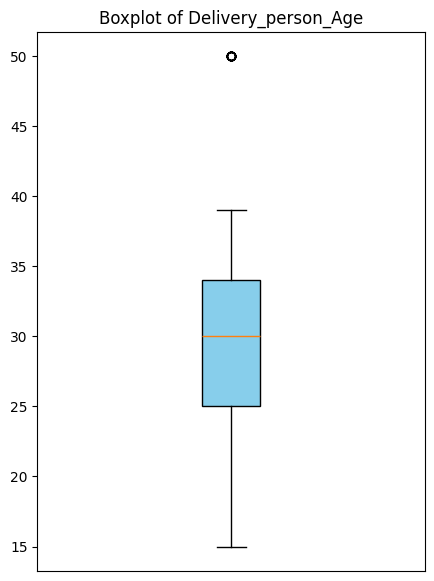

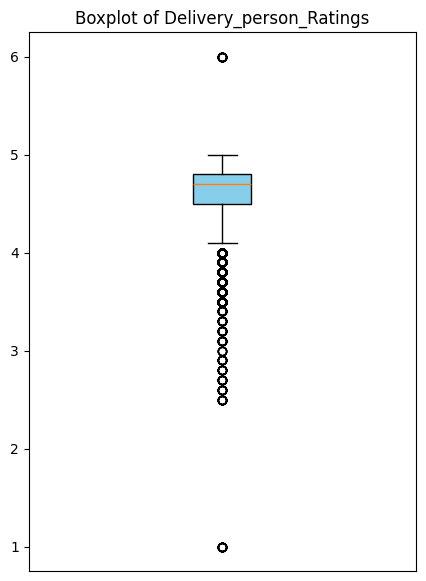

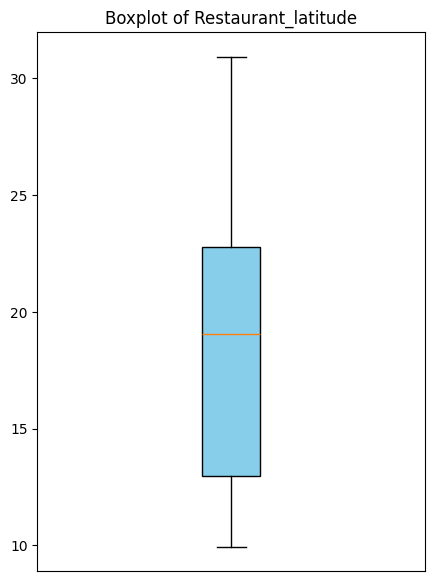

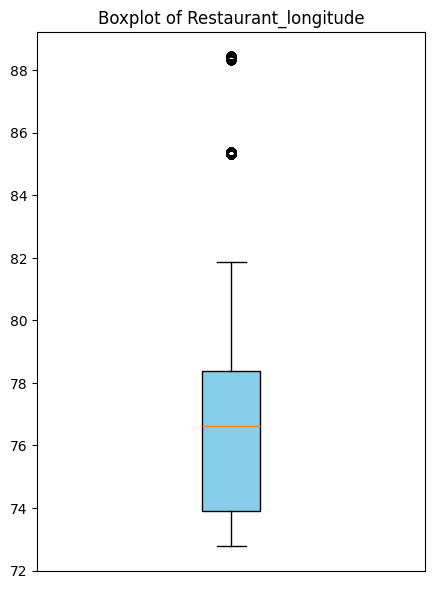

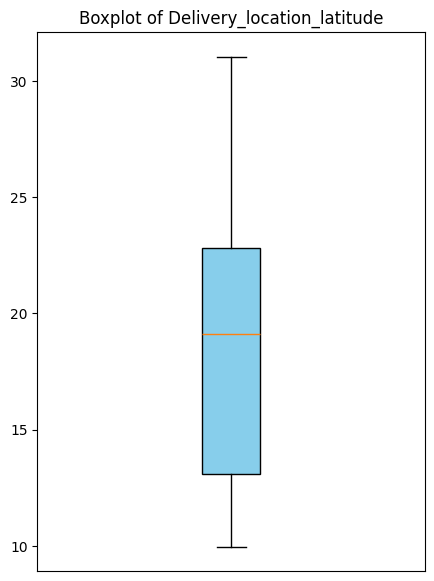

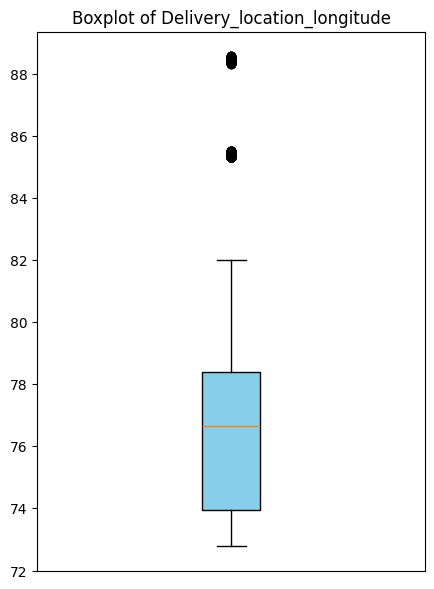

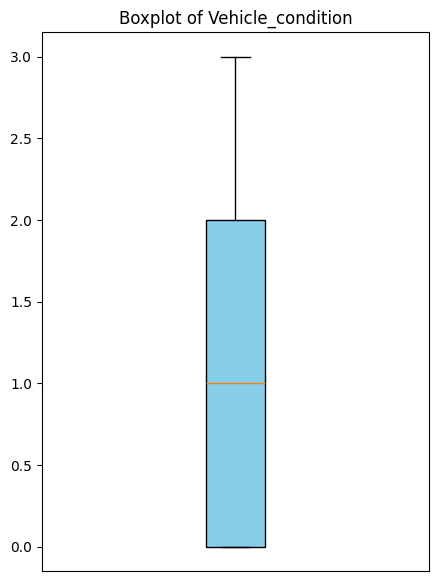

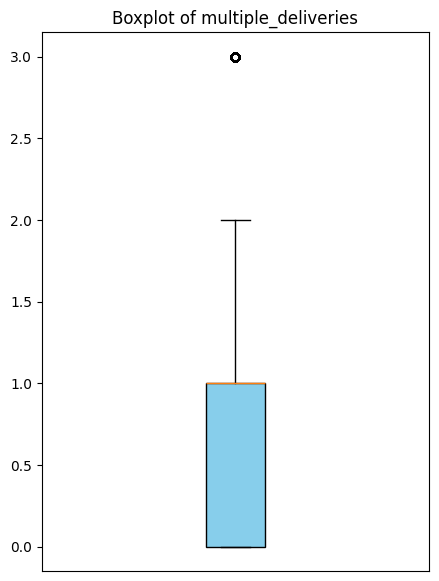

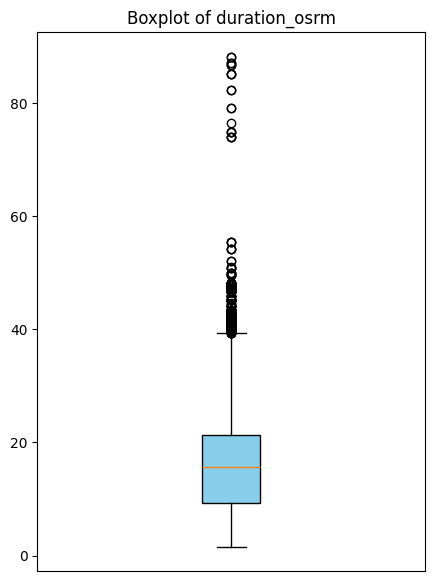

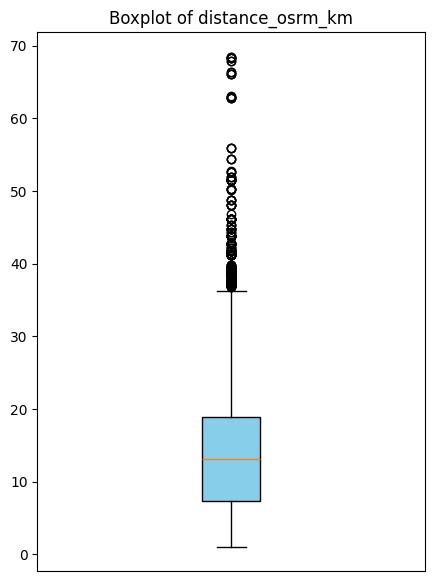

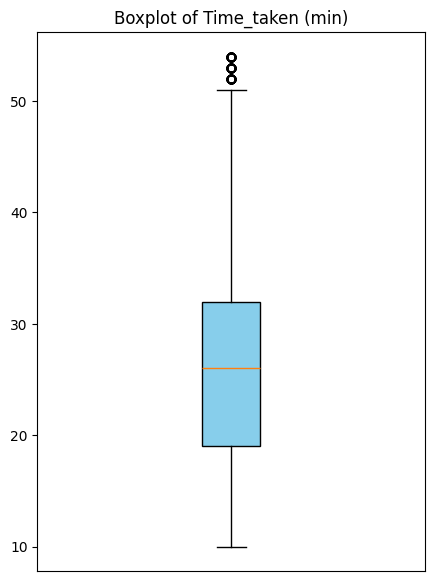

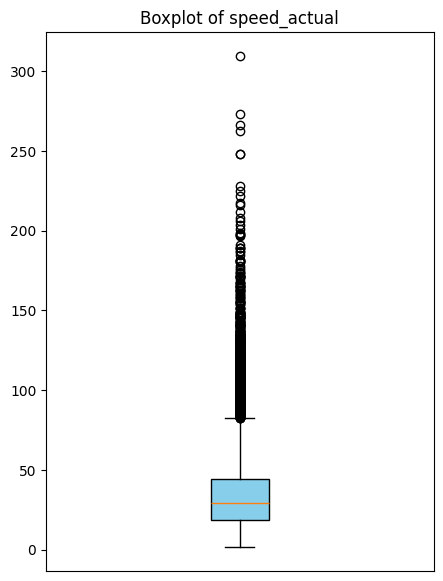

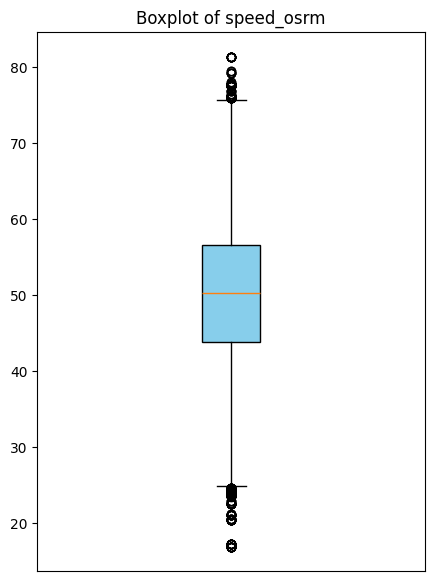

In [156]:
# Get numerical columns
numerical_features = train.select_dtypes(include=['number']).columns

# Create individual boxplots
for feature in numerical_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

In [157]:
len(train[train['speed_actual'] > 150])

83

In [158]:
len(test[test['speed_actual'] > 150])

16

In [159]:
# Maximum speed_actual -> 150 km/hour
train = train[train["speed_actual"] <= 150]
test = test[test["speed_actual"] <= 150]

In [160]:
len(train[train['speed_actual'] < 3])

22

In [161]:
len(test[test['speed_actual'] < 3])

6

In [162]:
# Minimum speed_actual -> 3 km/hour
train = train[train["speed_actual"] >= 3]
test = test[test["speed_actual"] >= 3]

In [163]:
train['speed_actual'].describe()

,speed_actual
count,33105.000000
mean,33.874330
std,22.113829
min,3.002043
25%,18.343814
50%,29.025545
75%,43.975459
max,149.277000


In [164]:
test['speed_actual'].describe()

,speed_actual
count,8281.000000
mean,33.652003
std,21.943201
min,3.038625
25%,18.330000
50%,28.825355
75%,43.681800
max,147.441882


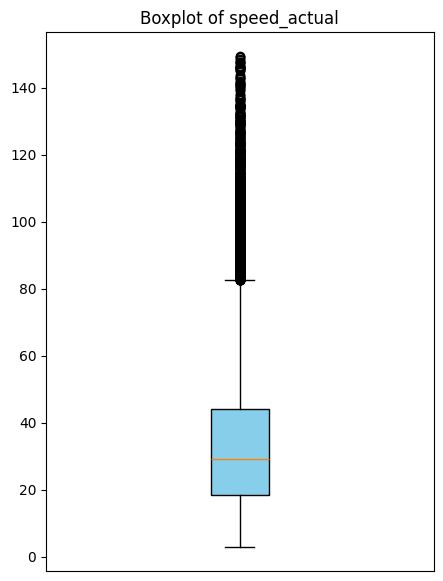

In [165]:
plt.figure(figsize=(5, 7))
plt.boxplot(train['speed_actual'], vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title("Boxplot of speed_actual")
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.show()

After removing outliers, it can be observed from the table and the boxplot that there are no extreme outliers. The data appears valid and natural.

## Route Visualization

I generated a projected best route using the OSRM API and visualized it on a Folium map. This allows us to better understand the driver’s actual route and provides more accurate estimates of both distance and travel time.

In [166]:
def parse_route(route_str):
    try:
        # Try JSON parsing first
        return json.loads(route_str)
    except json.JSONDecodeError:
        # Fallback: Use ast.literal_eval (safer than eval)
        return ast.literal_eval(route_str)

In [167]:
def visualize_multiple_routes(routes, restaurant_locs, delivery_locs, filename):
    m = folium.Map(location=[20.5937, 78.9629], zoom_start=6)

    for i, (route_str, r_loc, d_loc) in enumerate(zip(routes, restaurant_locs, delivery_locs)):
        # Parse the route string safely
        route = parse_route(route_str)

        folium.PolyLine(route, color='blue', weight=3, opacity=0.7).add_to(m)
        folium.Marker(r_loc, popup=f"Restaurant {i}", icon=folium.Icon(color='green', icon='cutlery')).add_to(m)
        folium.Marker(d_loc, popup=f"Delivery {i}", icon=folium.Icon(color='red', icon='flag')).add_to(m)

    m.save(filename)
    print(f"Map saved to {filename}")

In [168]:
# # Extract data
# restaurant_locs = list(zip(
#     train['Restaurant_latitude'].iloc[:50],
#     train['Restaurant_longitude'].iloc[:50]
# ))
# delivery_locs = list(zip(
#     train['Delivery_location_latitude'].iloc[:50],
#     train['Delivery_location_longitude'].iloc[:50]
# ))
# routes = train['route_coordinates_osrm'].iloc[:50].tolist()

In [169]:
# file_name = '/content/drive/MyDrive/Zomato Project/map/multi_route_map.html'

# # Generate the map
# visualize_multiple_routes(routes, restaurant_locs, delivery_locs, file_name)

In [170]:
# # Create a new DataFrame for production (Delivery Routes Visualization)
# route_prod = pd.DataFrame({
#     'restaurant_locs': restaurant_locs,
#     'delivery_locs': delivery_locs,
#     'routes': routes
# })

# csv_path = '/content/drive/MyDrive/Zomato Project/saved_csv/route_prod.csv'

# # Save to CSV
# route_prod.to_csv(csv_path, index=False)

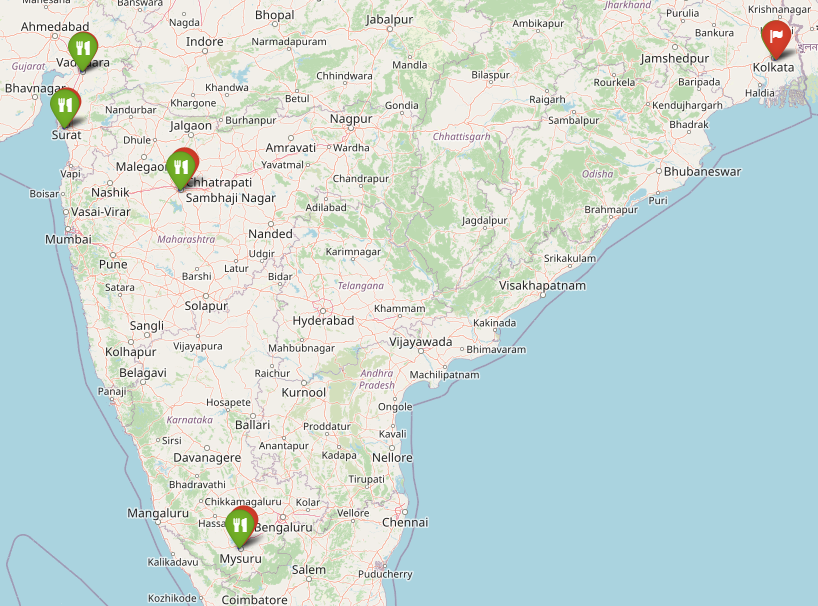

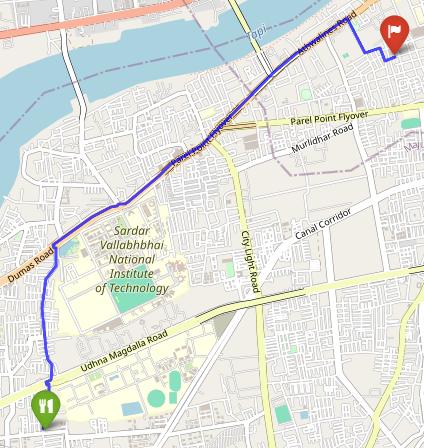

In [171]:
# # Create a new DataFrame for production (Traffic Jam Chart and Underperforming Drivers)

# charts_df = train.copy()
# charts_df = charts_df.drop('route_coordinates_osrm', axis=1)

# viz_path = '/content/drive/MyDrive/Zomato Project/saved_csv/charts.csv'

# # Save to CSV
# charts_df.to_csv(viz_path, index=False)

## Delivery Performance Analysis

In [172]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33105 entries, 22513 to 15795
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           33105 non-null  object        
 1   Delivery_person_ID           33105 non-null  object        
 2   Delivery_person_Age          33105 non-null  float64       
 3   Delivery_person_Ratings      33105 non-null  float64       
 4   Restaurant_latitude          33105 non-null  float64       
 5   Restaurant_longitude         33105 non-null  float64       
 6   Delivery_location_latitude   33105 non-null  float64       
 7   Delivery_location_longitude  33105 non-null  float64       
 8   Order_Date                   33105 non-null  datetime64[ns]
 9   Time_Orderd                  33105 non-null  object        
 10  Time_Order_picked            33105 non-null  object        
 11  Weather_conditions           33105 non-nul

### Calculate Performance Metrics

The performance metrics were defined

In [173]:
performance_train = train.groupby('Delivery_person_ID').agg({
    'Delivery_person_Ratings': 'mean',
    'Time_taken (min)': 'mean',
    'Vehicle_condition': 'mean',
    'speed_actual': 'mean',
    'speed_osrm': 'mean',
    'duration_osrm': 'mean',
    'distance_osrm_km': 'mean',
    'multiple_deliveries': 'mean',
    'ID': 'count'
}).rename(columns={
    'ID': 'Total_Deliveries',
    'duration_osrm': 'Avg_OSRM_Duration',
    'distance_osrm_km': 'Avg_OSRM_Distance'
}).reset_index()

In [174]:
# Calculate efficiency ratio (Actual Speed vs OSRM Speed)
performance_train['speed_ratio'] = performance_train['speed_actual'] / performance_train['speed_osrm']

In [175]:
performance_train.head()

,Delivery_person_ID,Delivery_person_Ratings,Time_taken (min),Vehicle_condition,speed_actual,speed_osrm,Avg_OSRM_Duration,Avg_OSRM_Distance,multiple_deliveries,Total_Deliveries,speed_ratio
0,AGRRES010DEL01,4.761538,25.230769,0.846154,34.053368,46.734949,16.447692,14.440877,0.538462,13,0.728649
1,AGRRES010DEL02,4.673333,28.800000,0.933333,38.166087,51.402475,18.380000,17.357007,0.933333,15,0.742495
2,AGRRES010DEL03,4.640000,29.100000,1.400000,38.370032,52.742183,19.074000,17.783130,0.900000,10,0.727502
3,AGRRES01DEL01,4.733333,25.000000,1.111111,32.086243,49.547317,13.435556,11.930089,0.888889,9,0.647588
4,AGRRES01DEL02,4.700000,24.750000,1.250000,43.496099,51.712927,18.979167,16.998150,0.416667,12,0.841107


In [176]:
performance_train[['Time_taken (min)','speed_ratio','Delivery_person_Ratings','Vehicle_condition']].describe()

,Time_taken (min),speed_ratio,Delivery_person_Ratings,Vehicle_condition
count,1170.000000,1170.000000,1170.000000,1170.000000
mean,26.396513,0.706963,4.636123,1.010550
std,2.312883,0.161678,0.081211,0.208126
min,17.333333,0.348480,4.066667,0.142857
25%,25.064918,0.595401,4.592857,0.900000
50%,26.281746,0.687753,4.640270,1.000000
75%,27.665000,0.796040,4.684555,1.125000
max,36.222222,1.740396,4.885714,1.769231


### Flag Underperformers

The Z-score tells us how far away (in standard deviations, σ) a value is from the mean (average).

Using the data above, the mean is ~26 minutes, and the standard deviation is ~2 minutes. Therefore:
- A Z-score of 1 means the time taken is 26 + 2 = 28 minutes.
- A Z-score of 2 means the time taken is 26 + (2 × 2) = 30 minutes.
- A Z-score of 3 means the time taken is 26 + (3 × 2) = 32 minutes.

Threshold Check (Z-score > 2):
- If a Z-score is greater than 2, it means the time taken is more than 2 standard deviations away from the mean.
- This is often considered an outlier (an unusually high or low value).
- Z > 2: Covers approximately 95.4% of the data within ±2 standard deviations.

In [177]:
# Time Efficiency Threshold (Z-score > 2 = 2σ from mean)
performance_train['time_zscore'] = np.abs(stats.zscore(performance_train['Time_taken (min)']))

The OSRM duration and distance were calculated using the car vehicle type, while the dataset includes unique values for vehicle types: `car`, `motorcycle`, `scooter`, `electric_scooter`, and `bicycle`. The general speed ranges for each vehicle type are as follows:
- Car: 60–100 km/h
- Motorcycle: 50–100 km/h
- Scooter: 30–50 km/h
- Electric Scooter: 20–40 km/h
- Bicycle: 15–25 km/h

To identify underperforming employees, I defined those as employees whose speed was less than 50% of the car's speed. Since an employee can use any vehicle type for delivery, this threshold helps isolate those who are underperforming based on the car's speed range.

In [178]:
# Speed Efficiency Threshold: Actual speed is less than 50% of OSRM's car speed prediction
performance_train['speed_flag'] = np.where(performance_train['speed_ratio'] < 0.5, 1, 0)

In [179]:
# Composite Underperformance Flags
performance_train['Underperformer'] = np.where(
    (performance_train['time_zscore'] > 2) |
    (performance_train['speed_flag'] == 1) |
    (performance_train['Delivery_person_Ratings'] < 3.5) |
    (performance_train['Vehicle_condition'] > 2),
    'Yes', 'No'
)

In [180]:
# Composite column for advanced underperformance flags
performance_train['Advanced_Flag'] = np.where(
    (performance_train['speed_ratio'] > 0.5) & (performance_train['Underperformer'] == 'Yes'),
    'High Speed, Long Time Taken',
    performance_train['Underperformer']
)

In [181]:
performance_train['Advanced_Flag'].value_counts()

,count
Advanced_Flag,
No,1013
Yes,93
"High Speed, Long Time Taken",64


In [182]:
performance_train.head()

,Delivery_person_ID,Delivery_person_Ratings,Time_taken (min),Vehicle_condition,speed_actual,speed_osrm,Avg_OSRM_Duration,Avg_OSRM_Distance,multiple_deliveries,Total_Deliveries,speed_ratio,time_zscore,speed_flag,Underperformer,Advanced_Flag
0,AGRRES010DEL01,4.761538,25.230769,0.846154,34.053368,46.734949,16.447692,14.440877,0.538462,13,0.728649,0.504238,0,No,No
1,AGRRES010DEL02,4.673333,28.800000,0.933333,38.166087,51.402475,18.380000,17.357007,0.933333,15,0.742495,1.039618,0,No,No
2,AGRRES010DEL03,4.640000,29.100000,1.400000,38.370032,52.742183,19.074000,17.783130,0.900000,10,0.727502,1.169382,0,No,No
3,AGRRES01DEL01,4.733333,25.000000,1.111111,32.086243,49.547317,13.435556,11.930089,0.888889,9,0.647588,0.604056,0,No,No
4,AGRRES01DEL02,4.700000,24.750000,1.250000,43.496099,51.712927,18.979167,16.998150,0.416667,12,0.841107,0.712192,0,No,No


### Visualization

In [183]:
# Update Advanced_Flag column with stakeholder-friendly labels
performance_train['Advanced_Flag'] = performance_train['Advanced_Flag'].replace({
    'Yes': 'Needs Improvement',
    'No': 'Meets Expectations'
})

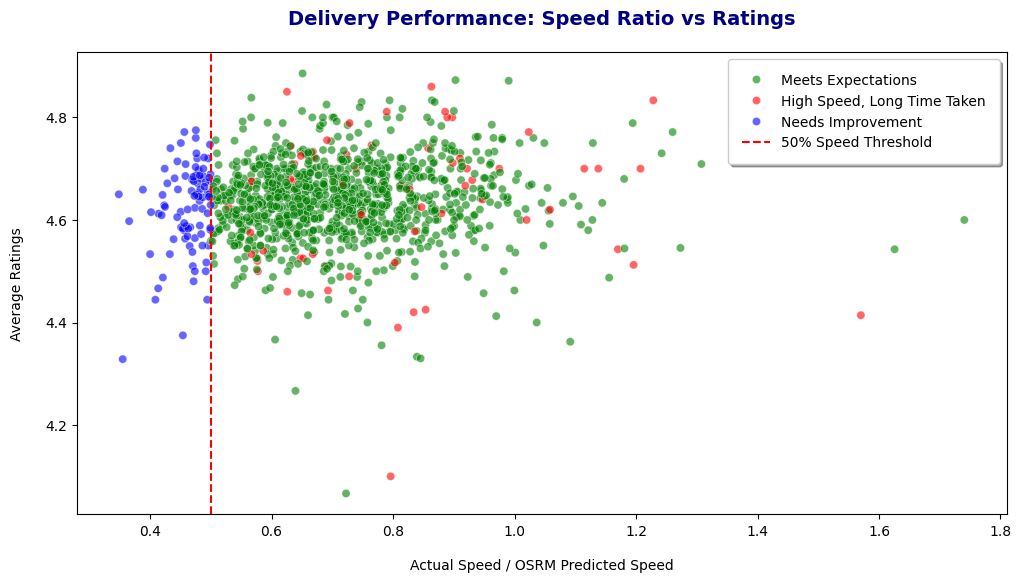

In [184]:
# Visualization 1: Speed Efficiency vs Ratings
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=performance_train,
    x='speed_ratio',
    y='Delivery_person_Ratings',
    hue='Advanced_Flag',
    palette={
        'Meets Expectations': 'green',
        'Needs Improvement': 'blue',
        'High Speed, Long Time Taken': 'red'
    },
    alpha=0.6
)
plt.title('Delivery Performance: Speed Ratio vs Ratings', fontsize=14, fontweight='bold', color='navy', pad = 20)
plt.xlabel('Actual Speed / OSRM Predicted Speed', fontsize=10, labelpad=15)
plt.ylabel('Average Ratings', fontsize=10, labelpad=15)
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Speed Threshold')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') # Check the overlapping points
plt.legend(fontsize=10, loc='upper right', frameon=True, shadow=True, fancybox=True, borderpad=1)
plt.show()

**Insight:**
- OSRM parameters for the car profile were used as the baseline to assess driver performance.
- Since drivers may use a variety of vehicles (Motorcycle, Bicycle, Electric Scooter, and Scooter), and one driver can switch between vehicle types, I used a speed ratio threshold of below 0.5 to identify underperforming drivers.
- Additionally, drivers were also considered underperforming if their actual travel time deviated by more than 2 standard deviations (approximately ±4 minutes) from the mean. For example, if the average actual time is 26 minutes, drivers with times above 30 minutes or below 22 minutes were flagged.

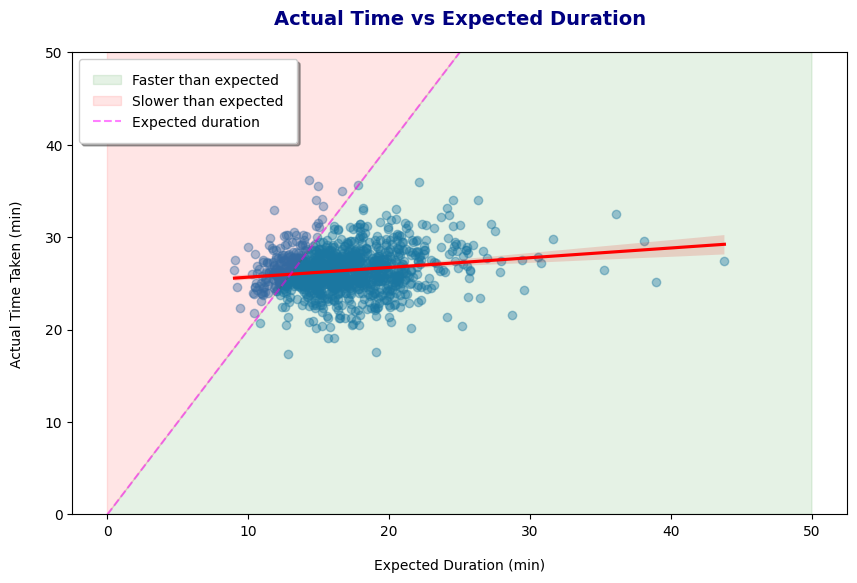

In [185]:
# Visualization 2: Time Taken vs OSRM Duration with shaded regions
plt.figure(figsize=(10, 6))

# Scatter plot and regression line
sns.regplot(
    data=performance_train,
    x='Avg_OSRM_Duration',
    y='Time_taken (min)',
    scatter_kws={'alpha': 0.4},
    line_kws={'color': 'red'}
)

# Shading the areas
x = np.linspace(0, 50, 500)  # Adjust range as necessary
y = 2*x  # Diagonal reference line

# Shade below diagonal (faster than predicted)
plt.fill_between(x, y, 0, color='green', alpha=0.1, label='Faster than expected')

# Shade above diagonal (slower than predicted)
plt.fill_between(x, y, 50, color='red', alpha=0.1, label='Slower than expected')

# Add reference line
plt.plot(x, y, '--', color='magenta', label='Expected duration', alpha=0.5)

# Title and labels
plt.title('Actual Time vs Expected Duration', fontsize=14, fontweight='bold', color='navy', pad=20)
plt.xlabel('Expected Duration (min)', fontsize=10, labelpad=15)
plt.ylabel('Actual Time Taken (min)', fontsize=10, labelpad=15)

# Set y-axis limit
plt.ylim(0, 50)

# Legend
plt.legend(fontsize=10, loc='upper left', frameon=True, shadow=True, fancybox=True, borderpad=1)

plt.show()

**Insight:**
- Similar to the previous chart, this shows the expected travel duration from the OSRM API using the car profile as the baseline. I flagged drivers as slower than expected if their actual travel time was less than 50% of the OSRM expected duration.
- Based on this threshold, most drivers (in the green-shaded area) were faster than expected, while a few (in the red-shaded area) were slower than expected.

### Generate Performance Report

This report summarizes the underperforming drivers.

In [186]:
underperformers = performance_train[performance_train['Underperformer'] == 'Yes']

# Select and round the desired columns
table_data = underperformers[[
    'Delivery_person_ID',
    'Delivery_person_Ratings',
    'Time_taken (min)',
    'speed_ratio',
    'Vehicle_condition'
]].round(2).head(10)

# Print markdown-formatted table
print("="*111)
print(f"### Underperforming Drivers ({len(underperformers)}/{len(performance_train)})")
print("="*111)
print(tabulate(table_data, headers='keys', tablefmt='github', showindex=False))
print("")
print("="*111)
print("Key Performance Metrics:")
print("="*111)
print(f"Average Speed Ratio: {performance_train['speed_ratio'].mean():.2f}")
print(f"% Drivers Below Speed Threshold (Speed Ratio < 0.5): {(performance_train['speed_flag'].mean()*100):.1f}%")
print(f"Average Actual Time Taken: {performance_train['Time_taken (min)'].mean():.0f} minutes")
print(f"Average Expected Duration: {performance_train['Avg_OSRM_Duration'].mean():.0f} minutes")
print(f"Average Vehicle Condition: {performance_train['Vehicle_condition'].mean():.1f} out of 3")
print(f"Average Rating: {performance_train['Delivery_person_Ratings'].mean():.1f} out of 6")

### Underperforming Drivers (157/1170)
| Delivery_person_ID   |   Delivery_person_Ratings |   Time_taken (min) |   speed_ratio |   Vehicle_condition |
|----------------------|---------------------------|--------------------|---------------|---------------------|
| AGRRES03DEL02        |                      4.7  |              17.62 |          1.14 |                1.25 |
| AGRRES04DEL03        |                      4.59 |              30.29 |          0.47 |                0.86 |
| AGRRES05DEL01        |                      4.67 |              24    |          0.48 |                1.14 |
| AGRRES05DEL02        |                      4.58 |              28.6  |          0.46 |                0.7  |
| AGRRES08DEL02        |                      4.67 |              34    |          0.78 |                0.44 |
| AGRRES17DEL01        |                      4.75 |              35.5  |          0.45 |                0.3  |
| AGRRES20DEL03        |                      4.54 |             

## Dropping Unused Column

This column is not important for building machine learning models, as it is merely an identifier or a route coordinate.

In [187]:
cols_to_drop = ['ID','Delivery_person_ID','route_coordinates_osrm']

train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

## Checking Skewness

Skewness Interpretation
- 0 to ±0.5 → Nearly symmetric (No transformation needed)
- ±0.5 to ±1.0 → Moderately skewed (Mild transformation)
- \>±1.0 → Strongly skewed (Stronger transformation required)

In [188]:
train.skew(numeric_only = True)

,0
Delivery_person_Age,-0.010426
Delivery_person_Ratings,-2.395778
Restaurant_latitude,0.103612
Restaurant_longitude,1.191643
Delivery_location_latitude,0.104239
Delivery_location_longitude,1.190921
Vehicle_condition,0.064711
multiple_deliveries,0.280848
duration_osrm,0.701076
distance_osrm_km,0.762550


Some features are strongly skewed. However, since I plan to use tree-based models, feature transformation is not necessary.

## Train vs Test Distribution

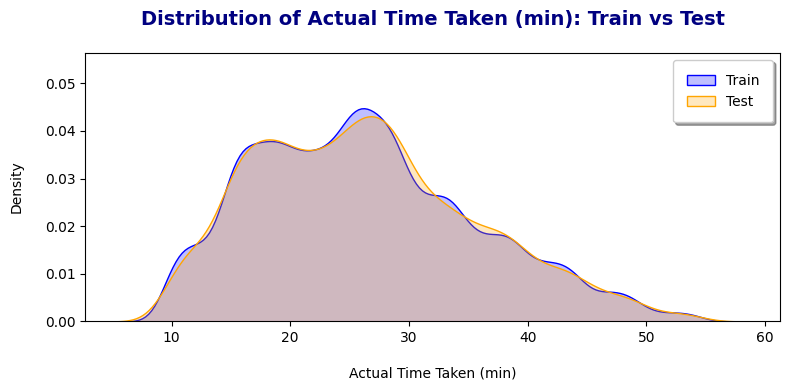

In [189]:
plt.figure(figsize=(8, 4))
sns.kdeplot(train["Time_taken (min)"], label='Train', fill=True, color='blue')
sns.kdeplot(test["Time_taken (min)"], label='Test', fill=True, color='orange')

plt.title('Distribution of Actual Time Taken (min): Train vs Test', fontsize=14, fontweight='bold', color='navy', pad=20)
plt.xlabel('Actual Time Taken (min)', fontsize=10, labelpad=15)
plt.ylabel('Density', fontsize=10, labelpad=15)
plt.legend(fontsize=10, loc='upper right', frameon=True, shadow=True, fancybox=True, borderpad=1)
plt.grid(False)

# Adjust the y-axis limit
current_ylim = plt.ylim()
plt.ylim(0, current_ylim[1] * 1.2)  # increase upper limit by 10%

plt.tight_layout()
plt.show()

The train and test distributions are similar and overlap, which suggests that the model can accurately predict the test set based on the training set.

## Correlation Matrix and VIF

I group the correlation strength into the following categories:
- Strong: Correlation strength ≥ 0.8 or ≤ -0.8
- Moderate: 0.3 < correlation strength < 0.8 or -0.8 < correlation strength < -0.3
- Weak: Correlation strength ≤ 0.3 and ≥ -0.3

In [190]:
def num_corr(df, corr_name='Correlation Matrix'):
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 6))
    correlation = df.corr(numeric_only=True)
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm', annot_kws={"size": 11})
    sns.despine(left=True, bottom=True)
    plt.grid(False)
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.title(f"{corr_name}", fontsize=16, fontweight='bold')

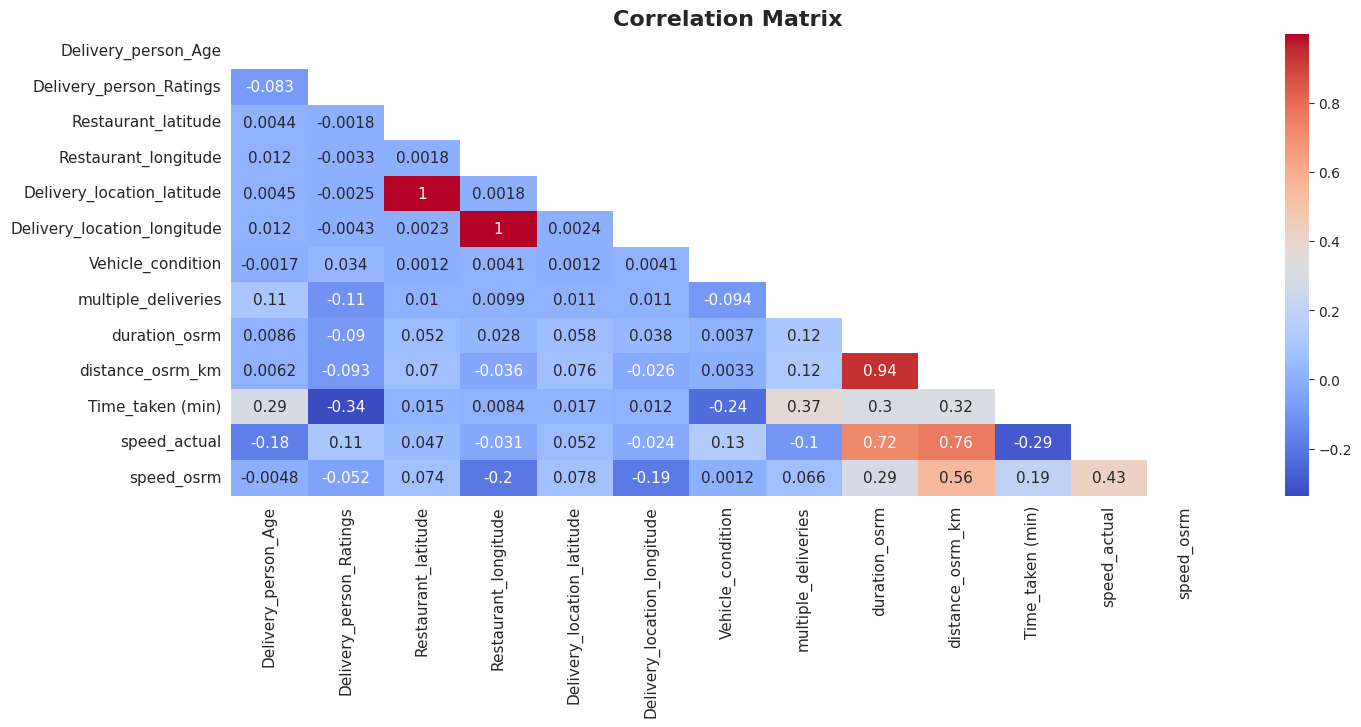

In [191]:
num_corr(train)

I group the strength of VIF into the following categories:
- No multicollinearity: VIF = 1
- Moderate multicollinearity: 5 ≤ VIF ≤ 10
- Severe multicollinearity: VIF > 10

In [192]:
# Calculate VIF for each feature

X_vif = train.drop(columns='Time_taken (min)')
X_vif = X_vif.select_dtypes(include='number')

# Add a constant to the DataFrame (required for VIF calculation)
X_vif = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df

,feature,VIF
3,Restaurant_latitude,1.801440e+15
5,Delivery_location_latitude,1.801440e+15
6,Delivery_location_longitude,6.928615e+14
4,Restaurant_longitude,6.928615e+14
10,distance_osrm_km,4.094096e+01
9,duration_osrm,3.031671e+01
12,speed_osrm,5.171630e+00
11,speed_actual,3.039241e+00
8,multiple_deliveries,1.117228e+00
2,Delivery_person_Ratings,1.094825e+00


Let's drop the features with high multicollinearity based on the correlation strength and VIF scores.

It's better to drop the `speed_actual` feature because it shows a high correlation with both `duration_osrm` and `distance_osrm_km`. Additionally, `speed_actual` is a derived feature, calculated by dividing `distance_osrm_km` by `Time_taken (min)`.

In [193]:
# Drop the high multicollinearity features
train = train.drop(columns=['Restaurant_latitude', 'Restaurant_longitude', 'distance_osrm_km', 'speed_actual'])
test = test.drop(columns=['Restaurant_latitude', 'Restaurant_longitude', 'distance_osrm_km', 'speed_actual'])

In [194]:
# Calculate VIF for each feature

X_vif = train.drop(columns='Time_taken (min)')
X_vif = X_vif.select_dtypes(include='number')

# Add a constant to the DataFrame (required for VIF calculation)
X_vif = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df

,feature,VIF
8,speed_osrm,1.150171
7,duration_osrm,1.120862
4,Delivery_location_longitude,1.048756
6,multiple_deliveries,1.046195
2,Delivery_person_Ratings,1.025461
1,Delivery_person_Age,1.018386
5,Vehicle_condition,1.010049
3,Delivery_location_latitude,1.007697


From the table, we can see that the VIF score is around 1 after removing the high multicollinearity features, which means there is no moderate multicollinearity. Therefore, there is no multicollinearity issue here.

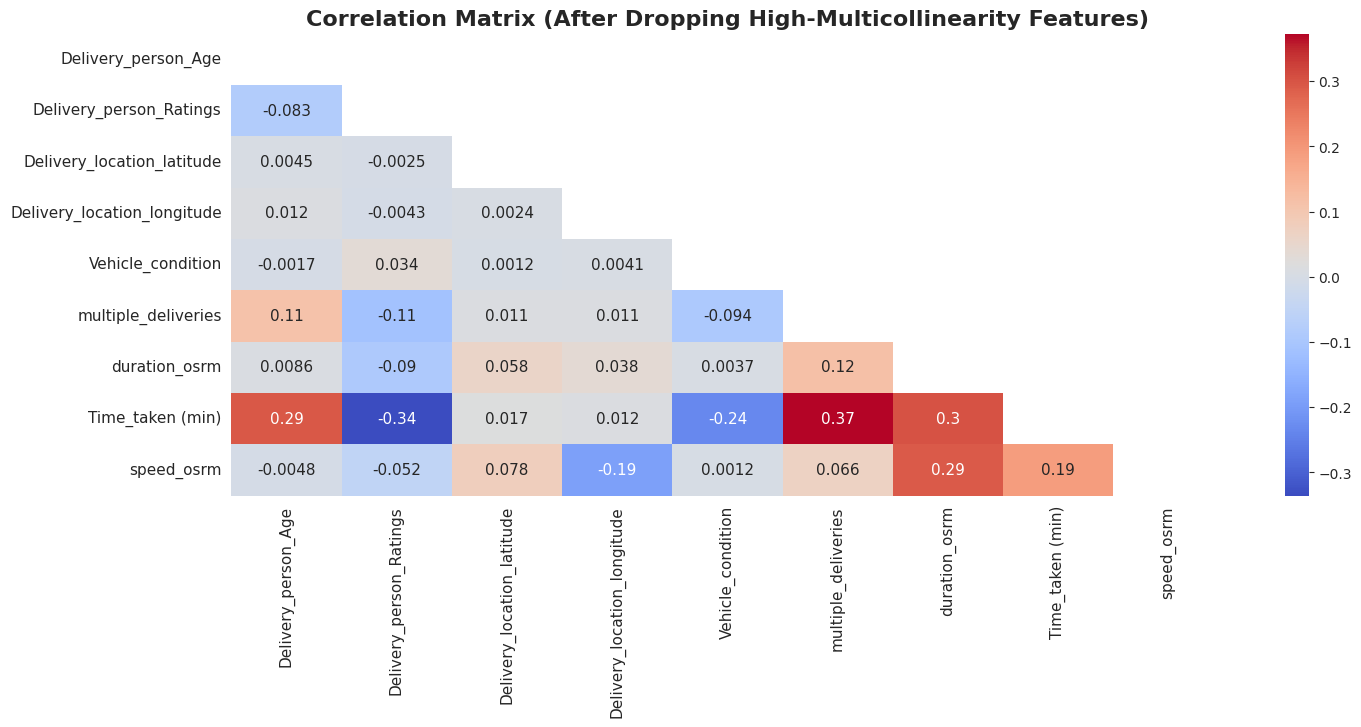

In [195]:
num_corr(train, 'Correlation Matrix (After Dropping High-Multicollinearity Features)')

Also, there is no high correlation strength observed in the correlation matrix after removing the high multicollinearity features.

# Feature Engineering

## Date-Time Extraction

In [196]:
# Extract day of week (0-6) and month (1-12)
train['Order_DayOfWeek'] = train['Order_Date'].dt.dayofweek  # Monday=0, Sunday=6
train['Order_Month'] = train['Order_Date'].dt.month          # January=1, December=12

test['Order_DayOfWeek'] = test['Order_Date'].dt.dayofweek  # Monday=0, Sunday=6
test['Order_Month'] = test['Order_Date'].dt.month          # January=1, December=12

In [197]:
# Convert to datetime
train['Time_Orderd'] = pd.to_datetime(train['Time_Orderd'], format='%H:%M').dt.time
train['Time_Order_picked'] = pd.to_datetime(train['Time_Order_picked'], format='%H:%M').dt.time

test['Time_Orderd'] = pd.to_datetime(test['Time_Orderd'], format='%H:%M').dt.time
test['Time_Order_picked'] = pd.to_datetime(test['Time_Order_picked'], format='%H:%M').dt.time

In [198]:
# Train -> Extract hour
train['Time_Orderd_Hour'] = train['Time_Orderd'].apply(lambda x: x.hour)
train['Time_Order_picked_Hour'] = train['Time_Order_picked'].apply(lambda x: x.hour)

# Test -> Extract hour
test['Time_Orderd_Hour'] = test['Time_Orderd'].apply(lambda x: x.hour)
test['Time_Order_picked_Hour'] = test['Time_Order_picked'].apply(lambda x: x.hour)

## Feature Encoding

### One-Hot Encoding (Dummy Encoding Version)

In [199]:
categorical_columns = ['Weather_conditions','Road_traffic_density','Type_of_order','Type_of_vehicle','Festival','City']

In [200]:
train = pd.get_dummies(train, columns=categorical_columns, dtype=int, drop_first=True)
test = pd.get_dummies(test, columns=categorical_columns, dtype=int, drop_first=True)

In [201]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33105 entries, 22513 to 15795
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Delivery_person_Age               33105 non-null  float64       
 1   Delivery_person_Ratings           33105 non-null  float64       
 2   Delivery_location_latitude        33105 non-null  float64       
 3   Delivery_location_longitude       33105 non-null  float64       
 4   Order_Date                        33105 non-null  datetime64[ns]
 5   Time_Orderd                       33105 non-null  object        
 6   Time_Order_picked                 33105 non-null  object        
 7   Vehicle_condition                 33105 non-null  int64         
 8   multiple_deliveries               33105 non-null  float64       
 9   duration_osrm                     33105 non-null  float64       
 10  Time_taken (min)                  33105 non-nul

In [202]:
train[[
    'Time_Orderd_Hour','Time_Order_picked_Hour','Order_DayOfWeek','Order_Month'
]].describe()

,Time_Orderd_Hour,Time_Order_picked_Hour,Order_DayOfWeek,Order_Month
count,33105.000000,33105.000000,33105.000000,33105.000000
mean,17.400604,17.128772,2.986679,3.002870
std,4.797769,5.298999,1.970704,0.530678
min,0.000000,0.000000,0.000000,2.000000
25%,15.000000,14.000000,1.000000,3.000000
50%,19.000000,19.000000,3.000000,3.000000
75%,21.000000,21.000000,5.000000,3.000000
max,23.000000,23.000000,6.000000,4.000000


### Cyclical Encoding

In [203]:
# Cyclical encoding for day of week
train['Order_DayOfWeek_sin'] = np.sin(2 * np.pi * train['Order_DayOfWeek'] / 7)
train['Order_DayOfWeek_cos'] = np.cos(2 * np.pi * train['Order_DayOfWeek'] / 7)

test['Order_DayOfWeek_sin'] = np.sin(2 * np.pi * test['Order_DayOfWeek'] / 7)
test['Order_DayOfWeek_cos'] = np.cos(2 * np.pi * test['Order_DayOfWeek'] / 7)

In [204]:
# Cyclical encoding for month
train['Order_Month_sin'] = np.sin(2 * np.pi * train['Order_Month'] / 12)
train['Order_Month_cos'] = np.cos(2 * np.pi * train['Order_Month'] / 12)

test['Order_Month_sin'] = np.sin(2 * np.pi * test['Order_Month'] / 12)
test['Order_Month_cos'] = np.cos(2 * np.pi * test['Order_Month'] / 12)

In [205]:
# Cyclical encoding for hour (more important than minute)
train['Time_Orderd_Hour_sin'] = np.sin(2 * np.pi * train['Time_Orderd_Hour'] / 24)
train['Time_Orderd_Hour_cos'] = np.cos(2 * np.pi * train['Time_Orderd_Hour'] / 24)
train['Time_Order_picked_Hour_sin'] = np.sin(2 * np.pi * train['Time_Order_picked_Hour'] / 24)
train['Time_Order_picked_Hour_cos'] = np.cos(2 * np.pi * train['Time_Order_picked_Hour'] / 24)

test['Time_Orderd_Hour_sin'] = np.sin(2 * np.pi * test['Time_Orderd_Hour'] / 24)
test['Time_Orderd_Hour_cos'] = np.cos(2 * np.pi * test['Time_Orderd_Hour'] / 24)
test['Time_Order_picked_Hour_sin'] = np.sin(2 * np.pi * test['Time_Order_picked_Hour'] / 24)
test['Time_Order_picked_Hour_cos'] = np.cos(2 * np.pi * test['Time_Order_picked_Hour'] / 24)

In [206]:
# Drop original columns
cols_to_drop = ['Order_Date','Order_DayOfWeek', 'Order_Month', 'Time_Orderd',
                'Time_Order_picked', 'Time_Orderd_Hour', 'Time_Order_picked_Hour']

# Drop original columns
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

In [207]:
train.describe()

,Delivery_person_Age,Delivery_person_Ratings,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,duration_osrm,Time_taken (min),speed_osrm,Weather_conditions_Fog,...,City_Semi-Urban,City_Urban,Order_DayOfWeek_sin,Order_DayOfWeek_cos,Order_Month_sin,Order_Month_cos,Time_Orderd_Hour_sin,Time_Orderd_Hour_cos,Time_Order_picked_Hour_sin,Time_Order_picked_Hour_cos
count,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,...,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,3.310500e+04,33105.000000,33105.000000,33105.000000,33105.000000
mean,29.594684,4.634832,18.969763,76.981688,1.012808,0.749857,16.042916,26.322942,50.372129,0.166531,...,0.008488,0.242471,0.016757,-0.017912,0.962270,-1.434829e-03,-0.483900,0.114478,-0.476450,0.136531
std,5.692349,0.323001,5.462386,3.496225,0.833183,0.565800,8.405558,9.369519,9.737566,0.372562,...,0.091741,0.428584,0.709557,0.704243,0.060261,2.653391e-01,0.567212,0.656528,0.555045,0.668059
min,15.000000,1.000000,9.967144,72.778726,0.000000,0.000000,1.600000,10.000000,16.950933,0.000000,...,0.000000,0.000000,-0.974928,-0.900969,0.866025,-5.000000e-01,-1.000000,-1.000000,-1.000000,-1.000000
25%,25.000000,4.500000,13.065662,73.940547,0.000000,0.000000,9.380000,19.000000,43.917660,0.000000,...,0.000000,0.000000,-0.781831,-0.900969,0.866025,6.123234e-17,-0.965926,-0.500000,-0.965926,-0.500000
50%,30.000000,4.700000,19.123249,76.662620,1.000000,1.000000,15.580000,26.000000,50.241328,0.000000,...,0.000000,0.000000,0.000000,-0.222521,1.000000,6.123234e-17,-0.707107,0.258819,-0.707107,0.258819
75%,34.000000,4.800000,22.821226,78.405467,2.000000,1.000000,21.320000,32.000000,56.622207,0.000000,...,0.000000,0.000000,0.781831,0.623490,1.000000,6.123234e-17,-0.258819,0.707107,-0.258819,0.707107
max,50.000000,6.000000,31.054057,88.563452,3.000000,3.000000,88.270000,54.000000,81.435941,1.000000,...,1.000000,1.000000,0.974928,1.000000,1.000000,5.000000e-01,0.866025,1.000000,0.866025,1.000000


In [208]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33105 entries, 22513 to 15795
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Delivery_person_Age               33105 non-null  float64
 1   Delivery_person_Ratings           33105 non-null  float64
 2   Delivery_location_latitude        33105 non-null  float64
 3   Delivery_location_longitude       33105 non-null  float64
 4   Vehicle_condition                 33105 non-null  int64  
 5   multiple_deliveries               33105 non-null  float64
 6   duration_osrm                     33105 non-null  float64
 7   Time_taken (min)                  33105 non-null  int64  
 8   speed_osrm                        33105 non-null  float64
 9   Weather_conditions_Fog            33105 non-null  int64  
 10  Weather_conditions_Sandstorms     33105 non-null  int64  
 11  Weather_conditions_Stormy         33105 non-null  int64  
 12  Weath

In [209]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8281 entries, 25875 to 139
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Delivery_person_Age               8281 non-null   float64
 1   Delivery_person_Ratings           8281 non-null   float64
 2   Delivery_location_latitude        8281 non-null   float64
 3   Delivery_location_longitude       8281 non-null   float64
 4   Vehicle_condition                 8281 non-null   int64  
 5   multiple_deliveries               8281 non-null   float64
 6   duration_osrm                     8281 non-null   float64
 7   Time_taken (min)                  8281 non-null   int64  
 8   speed_osrm                        8281 non-null   float64
 9   Weather_conditions_Fog            8281 non-null   int64  
 10  Weather_conditions_Sandstorms     8281 non-null   int64  
 11  Weather_conditions_Stormy         8281 non-null   int64  
 12  Weather_

---

**Check all types of encoding**

In [210]:
# To display all columns in a pandas DataFrame
pd.set_option('display.max_columns', None)  # Show all columns

In [211]:
df.loc[[22513, 28936, 12133]]

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),duration_osrm,route_coordinates_osrm,distance_osrm_km
22513,0x1772,MYSRES010DEL02,31.0,4.8,12.321214,76.621094,12.401214,76.701094,2022-03-20,18:45,19:00,Stormy,Medium,1,Snack,scooter,1.0,No,Metropolitian,24,22.00,"[(12.3211, 76.62126), (12.32072, 76.621), (12....",19.9700
28936,0xb71b,VADRES06DEL01,31.0,4.8,22.312790,73.170283,22.322790,73.180283,2022-03-13,09:25,09:30,Cloudy,Low,1,Meal,motorcycle,1.0,No,Metropolitian,15,3.84,"[(22.31293, 73.17028), (22.31293, 73.17085), (...",2.9664
12133,0xca6c,AURGRES14DEL02,21.0,5.0,19.875016,75.322405,19.955016,75.402405,2022-02-12,23:45,23:55,Cloudy,Low,0,Drinks,motorcycle,1.0,No,Metropolitian,20,20.39,"[(19.875, 75.32262), (19.87603, 75.32271), (19...",15.8098


In [212]:
train.head(3)

,Delivery_person_Age,Delivery_person_Ratings,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,duration_osrm,Time_taken (min),speed_osrm,Weather_conditions_Fog,Weather_conditions_Sandstorms,Weather_conditions_Stormy,Weather_conditions_Sunny,Weather_conditions_Windy,Road_traffic_density_Jam,Road_traffic_density_Low,Road_traffic_density_Medium,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Festival_Unknown,Festival_Yes,City_Semi-Urban,City_Urban,Order_DayOfWeek_sin,Order_DayOfWeek_cos,Order_Month_sin,Order_Month_cos,Time_Orderd_Hour_sin,Time_Orderd_Hour_cos,Time_Order_picked_Hour_sin,Time_Order_picked_Hour_cos
22513,31.0,4.8,12.401214,76.701094,1,1.0,22.00,24,54.463636,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,-0.781831,0.623490,1.000000,6.123234e-17,-1.000000,-1.836970e-16,-0.965926,0.258819
28936,31.0,4.8,22.322790,73.180283,1,1.0,3.84,15,46.350000,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,-0.781831,0.623490,1.000000,6.123234e-17,0.707107,-7.071068e-01,0.707107,-0.707107
12133,21.0,5.0,19.955016,75.402405,0,1.0,20.39,20,46.522217,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,-0.974928,-0.222521,0.866025,5.000000e-01,-0.258819,9.659258e-01,-0.258819,0.965926


In [213]:
df.loc[[25875, 12301, 2635]]

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),duration_osrm,route_coordinates_osrm,distance_osrm_km
25875,0x270e,MUMRES02DEL03,34.0,5.0,19.221315,72.862381,19.311315,72.952381,2022-03-25,23:50,23:55,Stormy,Low,2,Buffet,scooter,0.0,No,Metropolitian,19,27.27,"[(19.22137, 72.86238), (19.22137, 72.86277), (...",32.8070
12301,0x8fc4,MYSRES16DEL02,34.0,4.6,12.316967,76.603067,12.446967,76.733067,2022-03-25,20:30,20:35,Cloudy,Jam,0,Buffet,motorcycle,1.0,Yes,Metropolitian,50,30.93,"[(12.31698, 76.60317), (12.31705, 76.60316), (...",28.0956
2635,0x1308,HYDRES12DEL02,27.0,4.9,17.429585,78.392621,17.479585,78.442621,2022-03-30,00:00,00:10,Cloudy,Low,2,Buffet,scooter,1.0,No,Metropolitian,19,22.05,"[(17.42995, 78.39325), (17.43031, 78.39334), (...",13.9206


In [214]:
test.head(3)

,Delivery_person_Age,Delivery_person_Ratings,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,duration_osrm,Time_taken (min),speed_osrm,Weather_conditions_Fog,Weather_conditions_Sandstorms,Weather_conditions_Stormy,Weather_conditions_Sunny,Weather_conditions_Windy,Road_traffic_density_Jam,Road_traffic_density_Low,Road_traffic_density_Medium,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Festival_Unknown,Festival_Yes,City_Semi-Urban,City_Urban,Order_DayOfWeek_sin,Order_DayOfWeek_cos,Order_Month_sin,Order_Month_cos,Time_Orderd_Hour_sin,Time_Orderd_Hour_cos,Time_Order_picked_Hour_sin,Time_Order_picked_Hour_cos
25875,34.0,5.0,19.311315,72.952381,2,0.0,27.27,19,72.182618,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,-0.433884,-0.900969,1.0,6.123234e-17,-0.258819,0.965926,-0.258819,0.965926
12301,34.0,4.6,12.446967,76.733067,0,1.0,30.93,50,54.501649,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.433884,-0.900969,1.0,6.123234e-17,-0.866025,0.500000,-0.866025,0.500000
2635,27.0,4.9,17.479585,78.442621,2,1.0,22.05,19,37.879184,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.974928,-0.222521,1.0,6.123234e-17,0.000000,1.000000,0.000000,1.000000


**Print the Dataset for Testing the Model in Production**

In [215]:
test.shape

(8281, 35)

In [216]:
df.shape

(41513, 23)

---

**34 Features (without `Time_taken (min)`) for the test set**

In [217]:
test.sample(5, random_state = 42)

,Delivery_person_Age,Delivery_person_Ratings,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,duration_osrm,Time_taken (min),speed_osrm,Weather_conditions_Fog,Weather_conditions_Sandstorms,Weather_conditions_Stormy,Weather_conditions_Sunny,Weather_conditions_Windy,Road_traffic_density_Jam,Road_traffic_density_Low,Road_traffic_density_Medium,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Festival_Unknown,Festival_Yes,City_Semi-Urban,City_Urban,Order_DayOfWeek_sin,Order_DayOfWeek_cos,Order_Month_sin,Order_Month_cos,Time_Orderd_Hour_sin,Time_Orderd_Hour_cos,Time_Order_picked_Hour_sin,Time_Order_picked_Hour_cos
9000,31.0,4.7,17.460448,78.448213,1,1.0,11.05,18,41.831131,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0.433884,-0.900969,1.000000,6.123234e-17,-2.588190e-01,0.965926,-2.588190e-01,0.965926
18833,33.0,4.1,26.941411,75.813604,2,1.0,6.06,31,36.469307,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,-0.974928,-0.222521,1.000000,6.123234e-17,1.224647e-16,-1.000000,1.224647e-16,-1.000000
28075,39.0,4.9,19.074049,72.905203,0,1.0,12.91,36,65.151820,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0.000000,1.000000,0.866025,-5.000000e-01,-7.071068e-01,0.707107,-7.071068e-01,0.707107
11127,36.0,4.6,31.015915,75.918259,1,1.0,42.52,29,55.789558,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0.000000,1.000000,0.866025,5.000000e-01,-9.659258e-01,0.258819,-9.659258e-01,0.258819
10009,21.0,4.9,12.409524,76.752620,0,1.0,25.99,21,55.709273,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0.433884,-0.900969,1.000000,6.123234e-17,-2.588190e-01,0.965926,-2.588190e-01,0.965926


In [218]:
# Without "Time_taken (min)" feature
row_as_list = test.loc[[9000, 18833, 28075, 11127, 10009]].drop('Time_taken (min)', axis=1).values.tolist()

# Print each row as a separate list for easy selection
for idx, row in enumerate(row_as_list, 1):
    print(f"Row {idx}: {row}")

Row 1: [31.0, 4.7, 17.460448, 78.448213, 1.0, 1.0, 11.05, 41.83113122171945, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.43388373911755823, -0.900968867902419, 1.0, 6.123233995736766e-17, -0.25881904510252157, 0.9659258262890681, -0.25881904510252157, 0.9659258262890681]
Row 2: [33.0, 4.1, 26.941411, 75.813604, 2.0, 1.0, 6.06, 36.46930693069307, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.9749279121818236, -0.2225209339563146, 1.0, 6.123233995736766e-17, 1.2246467991473532e-16, -1.0, 1.2246467991473532e-16, -1.0]
Row 3: [39.0, 4.9, 19.074049, 72.905203, 0.0, 1.0, 12.91, 65.15182029434547, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8660254037844387, -0.4999999999999998, -0.7071067811865477, 0.7071067811865474, -0.7071067811865477, 0.7071067811865474]
Row 4: [36.0, 4.6, 31.015915, 75.918259, 1.0, 1.0, 42.52, 55.78955785512699, 0.0, 1.

---

**23 features for the df set. To view the original user input values**

In [219]:
df.loc[[9000, 18833, 28075, 11127, 10009]]

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),duration_osrm,route_coordinates_osrm,distance_osrm_km
9000,0x9589,HYDRES11DEL03,31.0,4.7,17.430448,78.418213,17.460448,78.448213,2022-03-24,23:25,23:30,Cloudy,Low,1,Meal,scooter,1.0,No,Metropolitian,18,11.05,"[(17.43067, 78.41812), (17.43114, 78.41745), (...",7.7039
18833,0x658c,JAPRES010DEL02,33.0,4.1,26.921411,75.793604,26.941411,75.813604,2022-03-05,12:00,12:15,Stormy,High,2,Meal,scooter,1.0,No,Metropolitian,31,6.06,"[(26.92145, 75.79383), (26.92152, 75.79382), (...",3.6834
28075,0x9f15,MUMRES09DEL02,39.0,4.9,18.994049,72.825203,19.074049,72.905203,2022-04-04,21:10,21:25,Stormy,Jam,0,Snack,motorcycle,1.0,No,Metropolitian,36,12.91,"[(18.99404, 72.82522), (18.99563, 72.82604), (...",14.0185
11127,0xca40,LUDHRES20DEL02,36.0,4.6,30.885915,75.788259,31.015915,75.918259,2022-02-14,19:40,19:55,Sandstorms,Jam,1,Meal,scooter,1.0,No,Metropolitian,29,42.52,"[(30.88607, 75.78818), (30.88588, 75.78765), (...",39.5362
10009,0x91dc,MYSRES03DEL01,21.0,4.9,12.299524,76.642620,12.409524,76.752620,2022-03-10,23:35,23:50,Fog,Low,0,Snack,motorcycle,1.0,No,Metropolitian,21,25.99,"[(12.2995, 76.64277), (12.3002, 76.64289), (12...",24.1314


In [220]:
# Resets max columns setting
pd.reset_option('display.max_columns')

# Model Building and Selection

**Reason for Choosing Tree-Based Models**
- Outliers: Tree-based models are less sensitive to outliers in the data. Since decision trees make splits based on feature values or percentiles (rather than distances), extreme values or outliers have minimal impact on the model's performance.
- Skewness: These models can naturally handle skewed features without requiring any specific transformations. Since tree-based models do not rely on assumptions of normality, they are well-suited for data with skewed distributions.
- Feature Scaling: Tree-based models do not require feature scaling. The splits in decision trees are determined by the values of the features themselves, not by their magnitudes, so normalization or standardization of features is not necessary.


**Reason for Choosing RMSE as the Primary Metric**
- Outliers: RMSE is particularly useful when there are outliers in the dataset, as it penalizes larger errors more heavily. This is beneficial when you want to ensure that large errors do not go unnoticed, especially in cases where outliers may be present.
- Target Values Near Zero: Since the dataset includes target variable values close to zero, using MAE (Mean Absolute Error) could lead to less sensitivity in capturing errors for small values. RMSE, on the other hand, is more sensitive to larger deviations, which makes it a better choice when trying to highlight and penalize significant errors, particularly in cases where small errors can still be crucial for model performance.

In [221]:
target_variable = 'Time_taken (min)'

X_train = train.drop([target_variable], axis = 1)
y_train = train[target_variable]

X_test = test.drop([target_variable], axis = 1)
y_test = test[target_variable]

In [222]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a regression model with timing"""
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train Time (s)': train_time,
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAE Train': mean_absolute_error(y_train, y_train_pred),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE Test': mean_absolute_error(y_test, y_test_pred),
        'RMSE Ratio (Test/Train)': np.sqrt(mean_squared_error(y_test, y_test_pred)) /
                                  np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAE Ratio (Test/Train)': mean_absolute_error(y_test, y_test_pred) /
                                 mean_absolute_error(y_train, y_train_pred)
    }
    return metrics

In [223]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)
}

In [224]:
# Store results
results = []

# Evaluate each model
for name, model in models.items():
    model_metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append({**model_metrics})

In [225]:
# Create results dataframe
results_df = pd.DataFrame(results).set_index('Model')

# Print formatted results
print("Enhanced Model Performance Comparison:")
print("="*147)
print(tabulate(results_df.round(2), headers='keys', tablefmt='github'))
print("="*147)

Enhanced Model Performance Comparison:
| Model         |   Train Time (s) |   RMSE Train |   MAE Train |   RMSE Test |   MAE Test |   RMSE Ratio (Test/Train) |   MAE Ratio (Test/Train) |
|---------------|------------------|--------------|-------------|-------------|------------|---------------------------|--------------------------|
| Random Forest |            48.57 |         1.64 |        1.27 |        4.33 |       3.38 |                      2.63 |                     2.65 |
| XGBoost       |             0.72 |         3.57 |        2.8  |        4.31 |       3.4  |                      1.21 |                     1.21 |
| LightGBM      |             0.64 |         4.12 |        3.27 |        4.26 |       3.37 |                      1.03 |                     1.03 |


**Overfitting/Underfitting Analysis**

For 'Time_taken (min)' prediction (in minutes):
- RMSE or MAE Ratio > 1.2 indicates overfitting
- RMSE or MAE Ratio < 1.0 suggests underfitting
- Ideal: Ratios between 1.0-1.2 (slight generalization gap is normal)

In [226]:
print("=== Model Performance Interpretation ===")
for index, row in results_df.iterrows():
    print(f"\n{index}:")
    if row['RMSE Ratio (Test/Train)'] > 1.2:
        print(f"  - OVERFITTING (RMSE ratio: {row['RMSE Ratio (Test/Train)']:.2f}) ⚠️")
    elif row['RMSE Ratio (Test/Train)'] < 1.0:
        print(f"  - Underfitting (RMSE ratio: {row['RMSE Ratio (Test/Train)']:.2f}) ⚠️")
    else:
        print(f"  - Good Generalization (RMSE ratio: {row['RMSE Ratio (Test/Train)']:.2f}) ✅")

    print(f"  - Training time: {row['Train Time (s)']:.2f} seconds")
    print(f"  - Test RMSE: {row['RMSE Test']:.2f} minutes (actual delivery time error)")

=== Model Performance Interpretation ===

Random Forest:
  - OVERFITTING (RMSE ratio: 2.63) ⚠️
  - Training time: 48.57 seconds
  - Test RMSE: 4.33 minutes (actual delivery time error)

XGBoost:
  - OVERFITTING (RMSE ratio: 1.21) ⚠️
  - Training time: 0.72 seconds
  - Test RMSE: 4.31 minutes (actual delivery time error)

LightGBM:
  - Good Generalization (RMSE ratio: 1.03) ✅
  - Training time: 0.64 seconds
  - Test RMSE: 4.26 minutes (actual delivery time error)


# Hyperparameter Tuning

In [227]:
# Tuning models
tuning_models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbosity=-1)
}

In [228]:
# Hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 75, 100],
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.2]
    },
    'LightGBM': {
        'n_estimators': [100, 150],
        'max_depth': [5, 7],
        'learning_rate': [0.1, 0.2]
    }
}

In [229]:
# Store results
results = []

# Tune and evaluate each model
for name, model in tuning_models.items():
    print(f"=== Tuning {name} ===")

    # GridSearchCV with reduced parameters
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    # Get best model
    best_model = search.best_estimator_

    # Evaluate
    model_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test, name)
    model_metrics['Best Params'] = str(search.best_params_)
    results.append(model_metrics)

    print(f"Best params: {search.best_params_}")
    print(f"Test RMSE: {model_metrics['RMSE Test']:.2f} minutes")

=== Tuning Random Forest ===
Best params: {'n_estimators': 100}
Test RMSE: 4.33 minutes
=== Tuning XGBoost ===
Best params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
Test RMSE: 4.29 minutes
=== Tuning LightGBM ===
Best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Test RMSE: 4.30 minutes


In [230]:
# Create results dataframe
results_df = pd.DataFrame(results).set_index('Model')

# Print formatted results
print("=== Tuned Models Performance ===")
print("="*149)
print(tabulate(results_df[['Best Params', 'RMSE Train', 'RMSE Test', 'MAE Test', 'RMSE Ratio (Test/Train)']].round(4), headers='keys', tablefmt='github'))
print("="*149)

=== Tuned Models Performance ===
| Model         | Best Params                                                 |   RMSE Train |   RMSE Test |   MAE Test |   RMSE Ratio (Test/Train) |
|---------------|-------------------------------------------------------------|--------------|-------------|------------|---------------------------|
| Random Forest | {'n_estimators': 100}                                       |       1.6444 |      4.3291 |     3.3784 |                    2.6327 |
| XGBoost       | {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100} |       3.8336 |      4.2939 |     3.384  |                    1.1201 |
| LightGBM      | {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150} |       3.8636 |      4.3003 |     3.3929 |                    1.113  |


In [231]:
# Performance interpretation
print("=== Key Takeaways ===")
best_model = results_df.loc[results_df['RMSE Test'].idxmin()]
print(f"Best model: {best_model.name} (Test RMSE: {best_model['RMSE Test']:.2f} mins)")

for index, row in results_df.iterrows():
    print(f"\n{index}:")
    print(f"Test RMSE: {row['RMSE Test']:.2f} mins")
    if row['RMSE Ratio (Test/Train)'] > 1.2:
        print(f"  - OVERFITTING (RMSE ratio: {row['RMSE Ratio (Test/Train)']:.2f}) ⚠️")
    elif row['RMSE Ratio (Test/Train)'] < 1.0:
        print(f"  - Underfitting (RMSE ratio: {row['RMSE Ratio (Test/Train)']:.2f}) ⚠️")
    else:
        print(f"  - Good Generalization (RMSE ratio: {row['RMSE Ratio (Test/Train)']:.2f}) ✅")

=== Key Takeaways ===
Best model: XGBoost (Test RMSE: 4.29 mins)

Random Forest:
Test RMSE: 4.33 mins
  - OVERFITTING (RMSE ratio: 2.63) ⚠️

XGBoost:
Test RMSE: 4.29 mins
  - Good Generalization (RMSE ratio: 1.12) ✅

LightGBM:
Test RMSE: 4.30 mins
  - Good Generalization (RMSE ratio: 1.11) ✅


# The Best Model and Its Interpretation

## Feature Importance

In [232]:
# Identify best model
best_model_name = results_df['RMSE Test'].idxmin()
best_model_params = eval(results_df.loc[best_model_name, 'Best Params'])
best_model = tuning_models[best_model_name].set_params(**best_model_params)
best_model.fit(X_train, y_train)

print(f"{'='*50}")
print(f"🏆 THE BEST MODEL: {best_model_name}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'RMSE Test']:.2f} minutes")
print(f"{'='*50}")

🏆 THE BEST MODEL: XGBoost
Test RMSE: 4.29 minutes


The best model is XGBoost, with an RMSE of 4.29 minutes. This means our predictions are, on average, off by 4.29 minutes. Considering that the standard deviation of the actual delivery times is around 9 minutes, this result is quite strong.

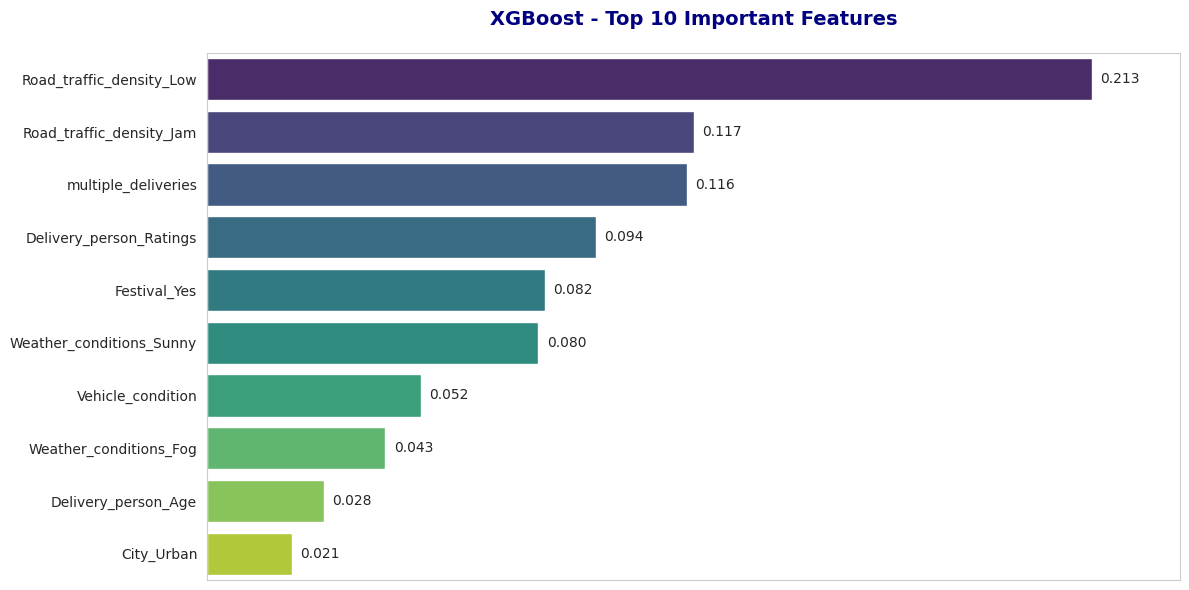


Top 10 Features:
                 Feature  Importance
Road_traffic_density_Low    0.213451
Road_traffic_density_Jam    0.117483
     multiple_deliveries    0.115802
 Delivery_person_Ratings    0.093844
            Festival_Yes    0.081523
Weather_conditions_Sunny    0.079984
       Vehicle_condition    0.051556
  Weather_conditions_Fog    0.043052
     Delivery_person_Age    0.028152
              City_Urban    0.020502


In [233]:
importances = best_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Determine new x-axis limit (e.g., 10% more than max value)
x_max = feat_imp['Importance'].max() * 1.10

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("viridis", len(feat_imp.head(10)))

# Use 'Feature' as hue to apply palette properly and avoid warning
ax = sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feat_imp.head(10),
    palette=palette,
    dodge=False,
    legend=False  # Remove redundant legend
)

# Set x-axis limit
ax.set_xlim(0, x_max)

# Title and labels
plt.title(f'{best_model_name} - Top 10 Important Features', fontsize=14, fontweight='bold', color='navy', pad = 20)
plt.xlabel('')
plt.ylabel('')

# Annotate bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.002, p.get_y() + p.get_height()/2,
            f'{width:.3f}', va='center', fontsize=10)

ax.grid(False)
ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()

# Print top features
print("\nTop 10 Features:")
print(feat_imp.head(10).to_string(index=False))

The top three most impactful factors influencing the **actual time taken** from the driver to the customer are `Road_traffic_density_low`, `Road_traffic_density_jam`, and `Multiple_deliveries`.

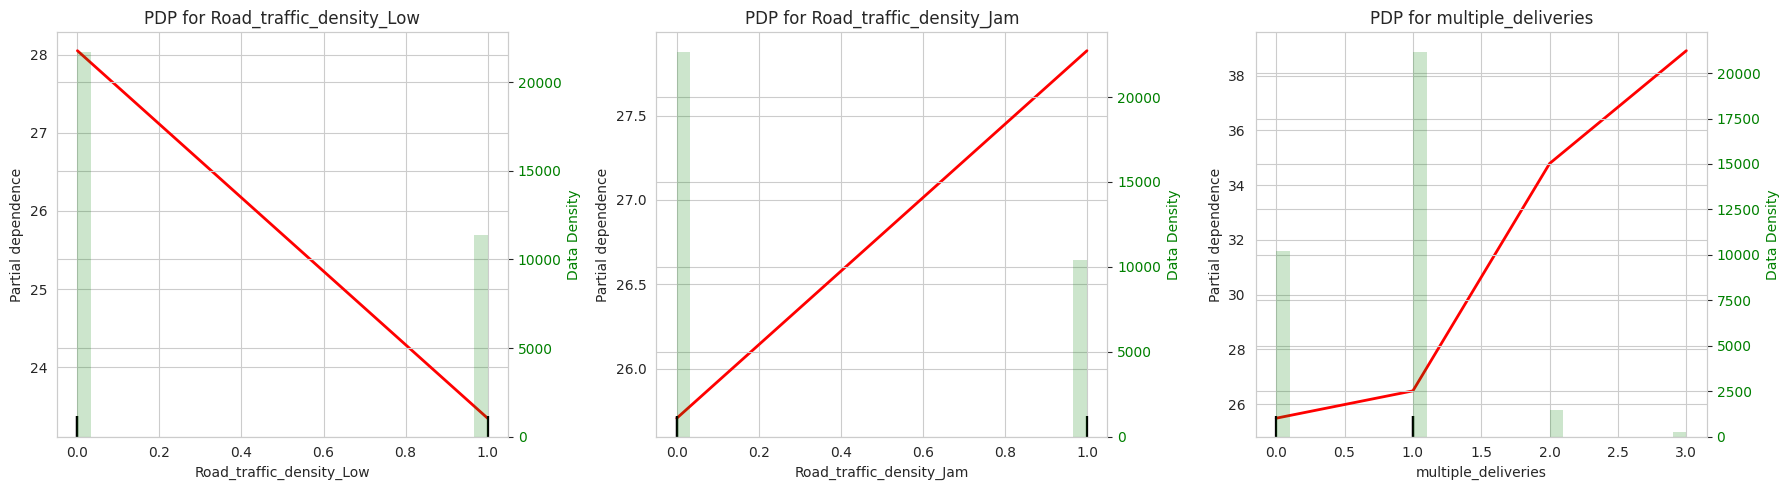

In [234]:
top_3_features = feat_imp.head(3)['Feature'].tolist()

# Create 1x3 subplot grid
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_3_features):
    # Create PDP plot
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,
        features=[feature],
        ax=ax[i],
        line_kw={"color": "red", "linewidth": 2}  # Removed invalid pd_line_kw
    )
    ax[i].set_title(f'PDP for {feature}')
    ax[i].set_ylabel('Delivery Time (min)')

    # Add actual data distribution
    twin_ax = ax[i].twinx()
    sns.histplot(
        x=X_train[feature],
        ax=twin_ax,
        color='green',
        alpha=0.2,
        bins=30,
        edgecolor='none'  # Improves visual clarity
    )
    twin_ax.set_ylabel('Data Density', color='green')
    twin_ax.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()

Note that I cannot change the y-label name on the partial dependence plots above to our target variable **(Time_taken (min))**, possibly due to the built-in force feature not allowing changes.

Based on the partial dependence plots above, we observe the following trends:
- Low Road Traffic Density: Lower road traffic density tends to reduce delivery time, likely because less congestion allows for faster travel between delivery points.
- Traffic Jams: On the other hand, traffic jams significantly increase delivery time, as drivers experience delays due to high congestion on the roads.
- Multiple Deliveries per Driver: Assigning multiple deliveries to a single driver contributes to longer delivery times, possibly due to increased route complexity and additional stops.


## Model Diagnosic

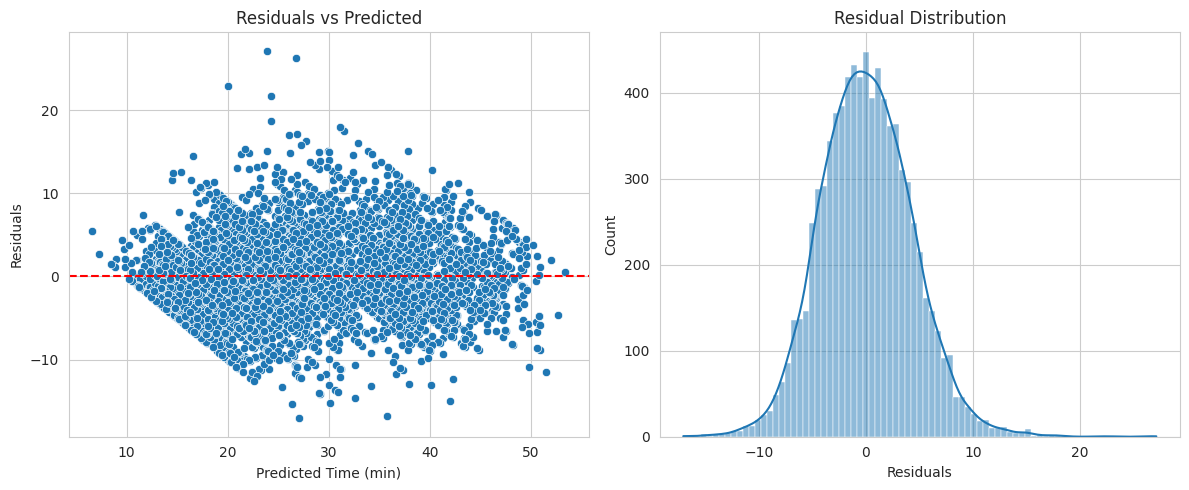

In [235]:
# Residual Analysis
y_test_pred = best_model.predict(X_test)
residuals = y_test - y_test_pred

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Time (min)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

**Insight:**
- From the model diagnostic above, we can observe that the residuals vs. predicted plot shows random variance with no apparent pattern. This suggests that our model is successfully capturing the underlying patterns in the dataset.
- Additionally, the residual distribution appears to follow a Gaussian distribution shape, indicating that the residuals are normally distributed, which is a good sign for the validity of the model.

In [236]:
# Error Analysis
print("====== Error Analysis ======")
error_stats = {
    'Mean Absolute Error': round(mean_absolute_error(y_test, y_test_pred), 2),
    'Mean Absolute % Error': round(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100, 2),
    'Max Overestimation': round(float(residuals.min()), 2),
    'Max Underestimation': round(float(residuals.max()), 2),
    'Std of Errors': round(float(residuals.std()), 2)
}

print(pd.DataFrame.from_dict(error_stats, orient='index', columns=['Value']))

====== Error Analysis ======
                       Value
Mean Absolute Error     3.38
Mean Absolute % Error  14.53
Max Overestimation    -17.07
Max Underestimation    27.14
Std of Errors           4.29


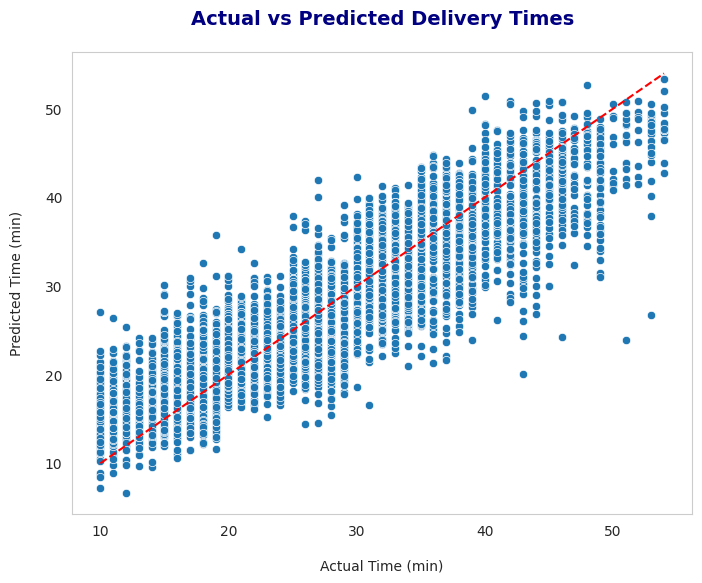

In [237]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Time (min)', fontsize=10, labelpad=15)
plt.ylabel('Predicted Time (min)', fontsize=10, labelpad=15)
plt.title('Actual vs Predicted Delivery Times', fontsize=14, fontweight='bold', color='navy', pad = 20)
plt.grid(False)
plt.show()

**Insight:**
- The graph comparing actual and predicted delivery times shows a strong linear relationship, closely following the line y = x.
- The red line represents this ideal relationship, indicating that, on average, the model’s predicted delivery times accurately reflect the actual delivery times.

In [238]:
# Business Interpretation
print("=============== Business Insights ===============")
avg_error = results_df.loc[best_model_name, 'RMSE Test']
print(f"• Average prediction error: {avg_error:.1f} minutes")
print(f"• 95% of predictions will be within ±{(avg_error*1.96):.1f} minutes")

if hasattr(best_model, 'feature_importances_'):
    print("\nTop 3 Impactful Features:")
    for i in range(3):
        print(f"{i+1}. {feat_imp.iloc[i].Feature} (importance: {feat_imp.iloc[i].Importance:.3f})")

=============== Business Insights ===============
• Average prediction error: 4.3 minutes
• 95% of predictions will be within ±8.4 minutes

Top 3 Impactful Features:
1. Road_traffic_density_Low (importance: 0.213)
2. Road_traffic_density_Jam (importance: 0.117)
3. multiple_deliveries (importance: 0.116)


# Business Recommendations

1. **Optimize Delivery Routes**: Utilize the OSRM API route projections to design optimized delivery routes, reducing delays caused by traffic and multiple deliveries.
2. **Optimize the Schedule**: Schedule deliveries during low-traffic periods (late night to morning) and adjust staffing levels to meet the high demand during peak order times (17:00-23:00).
3. **Focus on Driver Performance Improvement**: Provide targeted training or guidance for underperforming drivers.

# Save the Model for Deployment

## Save Best Model for Deployment

In [239]:
# Prepare model saving directory
model_dir = "/content/drive/MyDrive/Zomato Project/saved_models"
os.makedirs(model_dir, exist_ok=True)

In [240]:
# Create timestamped filename
timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"{model_dir}/{best_model_name}_{timestamp}.pkl"
metadata_filename = f"{model_dir}/{best_model_name}_{timestamp}_metadata.json"

In [241]:
# Save the model
joblib.dump(best_model, model_filename)

['/content/drive/MyDrive/Zomato Project/saved_models/XGBoost_20250510_085749.pkl']

In [242]:
# Save model metadata
metadata = {
    'model_name': best_model_name,
    'training_date': timestamp,
    'performance_metrics': {
        'RMSE': round(float(results_df.loc[best_model_name, 'RMSE Test']), 2),
        'MAE': round(float(results_df.loc[best_model_name, 'MAE Test']), 2),
        'AvgErrorMinutes': round(float(results_df.loc[best_model_name, 'RMSE Test']), 2)
    },
    'feature_importances': feat_imp.head(10).to_dict(orient='records') if 'feat_imp' in locals() else None,
    'hyperparameters': best_model_params
}

with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

In [243]:
# Save column names for future reference
pd.Series(X_train.columns).to_csv(f"{model_dir}/feature_columns.csv", index=False)

print(f"{'='*50}")
print(f"MODEL SAVED SUCCESSFULLY")
print(f"{'='*50}")
print(f"Model file: {model_filename}")
print(f"Metadata file: {metadata_filename}")
print(f"\nModel can be loaded with:")
print(f"joblib.load('{model_filename}')")

MODEL SAVED SUCCESSFULLY
Model file: /content/drive/MyDrive/Zomato Project/saved_models/XGBoost_20250510_085749.pkl
Metadata file: /content/drive/MyDrive/Zomato Project/saved_models/XGBoost_20250510_085749_metadata.json

Model can be loaded with:
joblib.load('/content/drive/MyDrive/Zomato Project/saved_models/XGBoost_20250510_085749.pkl')


## Create Deployment Package

In [244]:
print(f"{'='*50}")
print("DEPLOYMENT CHECKLIST")
print(f"{'='*50}")
print("1. Required files for deployment:")
print(f"   - Model file: {model_filename}")
print(f"   - Feature columns: {model_dir}/feature_columns.csv")
print("\n2. Quick load test:")
try:
    test_load = joblib.load(model_filename)
    print("   ✓ Model loads successfully")
    print(f"   ✓ Model type: {type(test_load)}")
except Exception as e:
    print(f"   ✗ Load failed: {str(e)}")

DEPLOYMENT CHECKLIST
1. Required files for deployment:
   - Model file: /content/drive/MyDrive/Zomato Project/saved_models/XGBoost_20250510_085749.pkl
   - Feature columns: /content/drive/MyDrive/Zomato Project/saved_models/feature_columns.csv

2. Quick load test:
   ✓ Model loads successfully
   ✓ Model type: <class 'xgboost.sklearn.XGBRegressor'>


In [245]:
print("Example prediction code:")
print("""
# Load model
model = joblib.load('{model_filename}')

# Load feature columns
feature_columns = pd.read_csv('{model_dir}/feature_columns.csv')[0].tolist()

# Prepare input data (example)
sample_input = pd.DataFrame([{{
    'feature1': value1,
    'feature2': value2,
    # ... other features
}}], columns=feature_columns)

# Make prediction
prediction = model.predict(sample_input)
print(f'Estimated delivery time: {prediction[0]:.1f} minutes')
""")

Example prediction code:

# Load model
model = joblib.load('{model_filename}')

# Load feature columns
feature_columns = pd.read_csv('{model_dir}/feature_columns.csv')[0].tolist()

# Prepare input data (example)
sample_input = pd.DataFrame([{{
    'feature1': value1,
    'feature2': value2,
    # ... other features
}}], columns=feature_columns)

# Make prediction
prediction = model.predict(sample_input)
print(f'Estimated delivery time: {prediction[0]:.1f} minutes')



## Generate Model Card

In [246]:
model_card = f"""
# Model Card: Delivery Time Prediction ({best_model_name})

## Model Details
- **Model Type**: {best_model_name}
- **Training Date**: {timestamp}
- **Target Variable**: Time_taken (minutes)

## Performance Metrics
| Metric | Value |
|--------|-------|
| Test RMSE | {metadata['performance_metrics']['RMSE']} mins |
| Test MAE | {metadata['performance_metrics']['MAE']} mins |

## Top 3 Features
1. {metadata['feature_importances'][0]['Feature']} (importance: {metadata['feature_importances'][0]['Importance']:.3f})
2. {metadata['feature_importances'][1]['Feature']} (importance: {metadata['feature_importances'][1]['Importance']:.3f})
3. {metadata['feature_importances'][2]['Feature']} (importance: {metadata['feature_importances'][2]['Importance']:.3f})

## Deployment Notes
- Input features must match the training schema
- Expected prediction error range: ±{(metadata['performance_metrics']['RMSE']*1.96):.1f} minutes (95% CI)
"""

with open(f"{model_dir}/{best_model_name}_{timestamp}_model_card.md", 'w') as f:
    f.write(model_card)

print(f"Model card saved to: {model_dir}/{best_model_name}_{timestamp}_model_card.md")

Model card saved to: /content/drive/MyDrive/Zomato Project/saved_models/XGBoost_20250510_085749_model_card.md


## Test the saved model

In [247]:
# Load the saved model
loaded_model = joblib.load(f'{model_filename}')

In [248]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [249]:
# Modified the speed_osrm and duration_osrm to 1 decimal.

# Row 1: [31.0, 4.7, 17.460448, 78.448213, 1.0, 1.0, 11.0, 41.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.43388373911755823, -0.900968867902419, 1.0, 6.123233995736766e-17, -0.25881904510252157, 0.9659258262890681, -0.25881904510252157, 0.9659258262890681]
# actual delivery time: 18 mins
# The model predicts: 19.5 mins

# Row 2: [33.0, 4.1, 26.941411, 75.813604, 2.0, 1.0, 6.1, 36.5, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.9749279121818236, -0.2225209339563146, 1.0, 6.123233995736766e-17, 1.2246467991473532e-16, -1.0, 1.2246467991473532e-16, -1.0]
# actual delivery time: 31 mins
# The model predicts: 32.8 mins

# Row 3: [39.0, 4.9, 19.074049, 72.905203, 0.0, 1.0, 12.9, 65.2, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8660254037844387, -0.4999999999999998, -0.7071067811865477, 0.7071067811865474, -0.7071067811865477, 0.7071067811865474]
# actual delivery time: 36 mins
# The model predicts: 36.6 mins

# Row 4: [36.0, 4.6, 31.015915, 75.918259, 1.0, 1.0, 42.5, 55.8, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8660254037844386, 0.5000000000000001, -0.9659258262890684, 0.2588190451025203, -0.9659258262890684, 0.2588190451025203]
# actual delivery time: 29 mins
# The model predicts: 30.5 mins

# Row 5: [21.0, 4.9, 12.409524, 76.75262, 0.0, 1.0, 26.0, 55.7, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43388373911755823, -0.900968867902419, 1.0, 6.123233995736766e-17, -0.25881904510252157, 0.9659258262890681, -0.25881904510252157, 0.9659258262890681]
# actual delivery time: 21 mins
# The model predicts: 24.6 mins

In [250]:
user_input = [21.0, 4.9, 12.409524, 76.75262, 0.0, 1.0, 26.0, 55.7, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43388373911755823, -0.900968867902419, 1.0, 6.123233995736766e-17, -0.25881904510252157, 0.9659258262890681, -0.25881904510252157, 0.9659258262890681]

# Convert the list to a numpy array and reshape it
input_array = np.array(user_input).reshape(1, -1)

# Predict
prediction = loaded_model.predict(input_array)

# Print result with 1 decimal place
print(f'Estimated delivery time: {prediction[0]:.1f} minutes')

Estimated delivery time: 24.6 minutes
